In [1]:
import netCDF4 as nc4
import numpy as np
import copy
import fates_func as ff
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
import pandas as pd
import time as tm
import xarray as xr
import os
import modp as mp
import rasterio
import rasterio.plot
from scipy.optimize import curve_fit
from scipy.stats import linregress

### Constants, options and predefined functions

In [39]:
nagebins = 51
nszbins = 13
npfts = 2
forest_area_ha = 2000.0
c_to_biomass = 2.0
m2_to_ha = 10000.0
abg_frac = 0.6

# nens = len(candidates)
nens = 638
# Initial candidates, i.e., all members
can_idx_all = np.arange(0,nens)

# Temporary diagnosis
diagnosis = False

# Path to all ensemble members
# # Some old runs
# block_path = '/pscratch/sd/s/sshu3/FATES_MRV/fates_mxbreeding254_spinup_2024-05-27_e9515ed7a8_664db78d/run/'
# block_prefix = 'fates_mxbreeding254_spinup_2024-05-27_e9515ed7a8_664db78d.elm_'
# block_path = '/pscratch/sd/s/sshu3/FATES_MRV/fates_mxbreeding254_spinup_2024-06-12_e9515ed7a8_664db78d/run/'
# block_prefix = 'fates_mxbreeding254_spinup_2024-06-12_e9515ed7a8_664db78d.elm_'
# block_path = '/pscratch/sd/s/sshu3/FATES_MRV/fates_mxbreeding254_spinup_2024-07-26_e9515ed7a8_664db78d/run/'
# block_prefix = 'fates_mxbreeding254_spinup_2024-07-26_e9515ed7a8_664db78d.elm_'
# block_path = '/pscratch/sd/s/sshu3/FATES_MRV/fates_mxbreeding254_spinup_2024-08-17_e9515ed7a8_664db78d/run/'
# block_prefix = 'fates_mxbreeding254_spinup_2024-08-17_e9515ed7a8_664db78d.elm_'
# 200 years spinup
# block_path = '/pscratch/sd/s/sshu3/FATES_MRV/fates_mxbreeding254_spinup_2024-08-29_e9515ed7a8_d8f0eb12/run/baseline/'
# block_prefix = 'fates_mxbreeding254_spinup_2024-08-29_e9515ed7a8_d8f0eb12.elm_'
# Area-based simulation results
# block_path = '/pscratch/sd/s/sshu3/FATES_MRV/fates_mxbreeding254_spinup_2024-07-26_e9515ed7a8_664db78d/run/hrv_area_0_3/'
# block_prefix = 'fates_mxbreeding254_spinup_2024-07-26_e9515ed7a8_664db78d.elm_'
# # 600 years spinup

# New candidates based on UAV LiDAR
block_n = 3
block_ens = [210, 210, 218]
# block_ens = [210]

# Path to all ensemble members
# block_path = ['/pscratch/sd/s/sshu3/FATES_MRV/fates_mxbreeding254_spinup_2024-09-12_e9515ed7a8_d8f0eb12/run/']
# block_prefix = ['fates_mxbreeding254_spinup_2024-09-12_e9515ed7a8_d8f0eb12.elm_']

block_path = ['/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_1_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/for_globus/post_2000/', \
              '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_2_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/for_globus/post_2000/', \
              '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_3_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/for_globus/post_2000/']
block_prefix = ['fates_uav_mxbreeding638_1_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_',\
               'fates_uav_mxbreeding638_2_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_', \
               'fates_uav_mxbreeding638_3_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_']

# Year number of model outputs
# fyear = [1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885
        # , 1890, 1895, 1900, 1905, 1910, 1915, 1920
        # , 1925, 1930, 1935, 1940, 1945
        # , 1950, 1955, 1960, 1965, 1970, 1975, 1980
        # , 1985, 1990, 1995, 2000, 2005, 2008, 2013, 2018] 
fyear = [2000, 2005, 2010, 2015]
# fyear = [2018, 2023, 2028, 2033, 2038, 2043, 2048, 2053, 2058, 2063, 2068, 2073, 2078, 2083, 2088, 2093, 2098]
nyr = len(fyear)*5
beg_year = fyear[0]
end_year = fyear[len(fyear)-1]+5


In [40]:
# Open the first file and read metadata
fpath = block_path[0]+block_prefix[0]+'0001.h0.'+str(fyear[0]).zfill(4)+'-02-01-00000.nc'
dtc = nc4.Dataset(fpath)
patch_age_bins = dtc['fates_levage'][:]
cohort_size_bins = dtc['fates_levscls'][:]
dtc.close()

### Read in history output

In [44]:
start = tm.time()

[arr_num_sz, arr_time, arr_tbot, arr_pco2, arr_pbot, arr_rain, arr_snow, arr_fsds, arr_gpp, arr_gpp_bl, arr_gpp_nl, \
 arr_npp, arr_npp_bl, arr_npp_nl, arr_lai, arr_lai_age, arr_leafc, arr_leafc_bl, arr_leafc_nl, arr_height_ca, arr_height_ba, \
 arr_vegc, arr_vegc_bl, arr_vegc_nl, arr_agb_sz, arr_reprodc, arr_sapwoodc, arr_storec, arr_frc, arr_rec, arr_mort, arr_mort_pf, \
 arr_mort_ustory, arr_ba, arr_num_can_sz, arr_num_ustory_sz, arr_ddbh_can_sz, arr_ddbh_ustory_sz, arr_spread, arr_litter, arr_soilc, \
 arr_age_patch, arr_age, arr_can_area, arr_logging_rate, arr_sec_frac, arr_wood_product, arr_germ, arr_co2_ppm] \
= ff.read_fatesmrv_outputs(block_n, block_ens, fyear, block_path, block_prefix, get_annual_mean=True)

end = tm.time()
print('Time elapsed: ', end - start)

Time elapsed:  85.607666015625


### Read in land use time series for validation

In [36]:
## Open and read in harvest rate data, C based
block_n = 3
block_ens = [210, 210, 218]
block_path = ['/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_1_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/', \
              '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_2_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/', \
              '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_3_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/']
block_prefix = 'landuse.timeseries_0.125x0.125_hist_simyr1850-2028.SanRafael.c231020_'
block_suffix = '_baseline.nc'

[vh1_ts, sh1_ts] = ff.read_hrvrate(block_n, block_ens, block_path, block_prefix, block_suffix)


### Read in parameter files and obtain required parameter values

In [46]:
# Open and collect wood density information from candidates within the ensemble
# Path to all members
wd = []
param_prefix = '/global/homes/s/sshu3/FATES_MRV/parameter_file_sandbox/uav_mx_breeding/fates_params_sr_ens_'
for i in np.arange(0,nens):
    ens_num = str(i+1).zfill(4)
    fpath = param_prefix+ens_num+'.nc'
    dtc = nc4.Dataset(fpath)
    tmp = dtc['fates_wood_density'][:]
    wd.append(tmp[0])
    dtc.close()

# from g cm-3 to kg m-3
arr_wd = 1000.0 * np.array(wd)

### (Optional) Read in history outputs from different experiments

In [26]:
nagebins = 51
nszbins = 13
npfts = 2
forest_area_ha = 2000.0
c_to_biomass = 2.0
m2_to_ha = 10000.0
abg_frac = 0.6

# nens = len(candidates)
nens = 638
# Initial candidates, i.e., all members
can_idx_all = np.arange(0,nens)

# Get multi-annual mean instead of time series
get_mean = False
# Temporary diagnosis
diagnosis = False
# More FATES output variables which are inactive by default
additional_vars = False

# Path to all ensemble members
# New candidates based on UAV LiDAR
block_n = 3
block_ens = [210, 210, 218]
ncase = 4

# Path to all ensemble members
block_path = ['/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_1_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/for_globus/', \
              '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_2_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/for_globus/', \
              '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_3_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/for_globus/']
block_case = ['extend_rot/', 'gaussianlog_hrv/', 'invlog_hrv/', 'log_harv/']
block_prefix = ['fates_uav_mxbreeding638_1_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_',\
               'fates_uav_mxbreeding638_2_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_', \
               'fates_uav_mxbreeding638_3_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_']

# Year number of model outputs
# fyear = [1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885
        # , 1890, 1895, 1900, 1905, 1910, 1915, 1920
        # , 1925, 1930, 1935, 1940, 1945
        # , 1950, 1955, 1960, 1965, 1970, 1975, 1980
        # , 1985, 1990, 1995, 2000, 2005, 2008, 2013, 2018] 
# fyear = [201, 301, 401, 501]
fyear = [2018]
nyr = len(fyear)*5
beg_year = fyear[0]
end_year = fyear[len(fyear)-1]+5


In [3]:
# Open the first file and read metadata
fpath = block_path[0]+block_case[0]+block_prefix[0]+'0001.h0.'+str(fyear[0]).zfill(4)+'-02-01-00000.nc'
dtc = nc4.Dataset(fpath)
patch_age_bins = dtc['fates_levage'][:]
cohort_size_bins = dtc['fates_levscls'][:]
dtc.close()

In [33]:
# New blank lists
# CLimate vars
tbot_collect, pco2_collect, pbot_collect, rain_collect, fsds_collect, snow_collect = ([] for i in range(6))

# Demographic vars
num_sz_collect, time_collect, height_ca_collect, height_ba_collect, age_patch_collect, age_collect, can_area_collect, ba_collect, num_can_sz_collect,                num_ustory_sz_collect = ([] for i in range(10))

# Physiological vars
gpp_collect, gpp_bl_collect, gpp_nl_collect, npp_collect, npp_bl_collect, npp_nl_collect, lai_collect, lai_age_collect = ([] for i in range(8))
vegc_collect, vegc_bl_collect, vegc_nl_collect, leafc_collect, leafc_bl_collect, leafc_nl_collect, reprodc_collect, sapwoodc_collect, storec_collect, frc_collect =  ([] for i in range(10))
rec_collect, mort_pf_collect, mort_collect, mort_ustory_collect, ddbh_can_sz_collect, ddbh_ustory_sz_collect, litter_collect, spread_collect, soilc_collect = ([]    for i in range(9))

for i in np.arange(0, ncase):
    for j in np.arange(0, block_n):
        block_path[j] = block_path[j] + block_case[i]
    [arr_num_sz, arr_time, arr_tbot, arr_pco2, arr_pbot, arr_rain, arr_snow, arr_fsds, arr_gpp, arr_gpp_bl, arr_gpp_nl, \
     arr_npp, arr_npp_bl, arr_npp_nl, arr_lai, arr_lai_age, arr_leafc, arr_leafc_bl, arr_leafc_nl, arr_height_ca, arr_height_ba, \
     arr_vegc, arr_vegc_bl, arr_vegc_nl, arr_reprodc, arr_sapwoodc, arr_storec, arr_frc, arr_rec, arr_mort, arr_mort_pf, \
     arr_mort_ustory, arr_ba, arr_num_can_sz, arr_num_ustory_sz, arr_ddbh_can_sz, arr_ddbh_ustory_sz, arr_spread, arr_litter, arr_soilc, \
     arr_age_patch, arr_age, arr_can_area, arr_logging_rate, arr_sec_frac, arr_wood_product, arr_germ, arr_co2_ppm] \
    = ff.read_fatesmrv_outputs(block_n, block_ens, fyear, block_path, block_prefix, get_annual_mean=True)
    # Reset path
    block_path = ['/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_1_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/for_globus/', \
              '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_2_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/for_globus/', \
              '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_3_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/for_globus/']
    # Concatenate all cases
    tbot_collect.append(arr_tbot)
    pco2_collect.append(arr_pco2)
    pbot_collect.append(arr_pbot)
    rain_collect.append(arr_rain)
    fsds_collect.append(arr_fsds)
    snow_collect.append(arr_snow)
    num_sz_collect.append(arr_num_sz)
    time_collect.append(arr_time)
    height_ca_collect.append(arr_height_ca)
    height_ba_collect.append(arr_height_ba)
    age_patch_collect.append(arr_age_patch)
    age_collect.append(arr_age)
    can_area_collect.append(arr_can_area)
    ba_collect.append(arr_ba)
    num_can_sz_collect.append(arr_num_can_sz)
    num_ustory_sz_collect.append(arr_num_ustory_sz)
    gpp_collect.append(arr_gpp)
    gpp_bl_collect.append(arr_gpp_bl)
    gpp_nl_collect.append(arr_gpp_nl)
    npp_collect.append(arr_npp)
    npp_bl_collect.append(arr_npp_bl)
    npp_nl_collect.append(arr_npp_nl)
    lai_collect.append(arr_lai)
    lai_age_collect.append(arr_lai_age)
    vegc_collect.append(arr_vegc)
    vegc_bl_collect.append(arr_vegc_bl)
    vegc_nl_collect.append(arr_vegc_nl)
    leafc_collect.append(arr_leafc)
    leafc_bl_collect.append(arr_leafc_bl)
    leafc_nl_collect.append(arr_leafc_nl)
    reprodc_collect.append(arr_reprodc)
    sapwoodc_collect.append(arr_sapwoodc)
    storec_collect.append(arr_storec)
    frc_collect.append(arr_frc)
    rec_collect.append(arr_rec)
    mort_pf_collect.append(arr_mort_pf)
    mort_collect.append(arr_mort)
    mort_ustory_collect.append(arr_mort_ustory)
    ddbh_can_sz_collect.append(arr_ddbh_can_sz)
    ddbh_ustory_sz_collect.append(arr_ddbh_ustory_sz)
    litter_collect.append(arr_litter)
    spread_collect.append(arr_spread)
    soilc_collect.append(arr_soilc)

arr_tbot_allexp = np.array(tbot_collect)
arr_pco2_allexp = np.array(pco2_collect)
arr_pbot_allexp = np.array(pbot_collect)
arr_rain_allexp = np.array(rain_collect)
arr_fsds_allexp = np.array(fsds_collect)
arr_snow_allexp = np.array(snow_collect)
arr_num_sz_allexp = np.array(num_sz_collect)
arr_time_allexp = np.array(time_collect)
arr_height_ca_allexp = np.array(height_ca_collect)
arr_height_ba_allexp = np.array(height_ba_collect)
arr_age_patch_allexp = np.array(age_patch_collect)
arr_age_allexp = np.array(age_collect)
arr_can_area_allexp = np.array(can_area_collect)
arr_ba_allexp = np.array(ba_collect)
arr_num_can_sz_allexp = np.array(num_can_sz_collect)
arr_num_ustory_sz_allexp = np.array(num_ustory_sz_collect)
arr_gpp_allexp = np.array(gpp_collect)
arr_gpp_bl_allexp = np.array(gpp_bl_collect)
arr_gpp_nl_allexp = np.array(gpp_nl_collect)
arr_npp_allexp = np.array(npp_collect)
arr_npp_bl_allexp = np.array(npp_bl_collect)
arr_npp_nl_allexp = np.array(npp_nl_collect)
arr_lai_allexp = np.array(lai_collect)
arr_lai_age_allexp = np.array(lai_age_collect)
arr_vegc_allexp = np.array(vegc_collect)
arr_vegc_bl_allexp = np.array(vegc_bl_collect)
arr_vegc_nl_allexp = np.array(vegc_nl_collect)
arr_leafc_allexp = np.array(leafc_collect)
arr_leafc_bl_allexp = np.array(leafc_bl_collect)
arr_leafc_nl_allexp = np.array(leafc_nl_collect)
arr_reprodc_allexp = np.array(reprodc_collect)
arr_sapwoodc_allexp = np.array(sapwoodc_collect)
arr_storec_allexp = np.array(storec_collect)
arr_frc_allexp = np.array(frc_collect)
arr_rec_allexp = np.array(rec_collect)
arr_mort_pf_allexp = np.array(mort_pf_collect)
arr_mort_allexp = np.array(mort_collect)
arr_mort_ustory_allexp = np.array(mort_ustory_collect)
arr_ddbh_can_sz_allexp = np.array(ddbh_can_sz_collect)
arr_ddbh_ustory_sz_allexp = np.array(ddbh_ustory_sz_collect)
arr_litter_allexp = np.array(litter_collect)
arr_spread_allexp = np.array(spread_collect)
arr_soilc_allexp = np.array(soilc_collect)

### Diagnose age structure

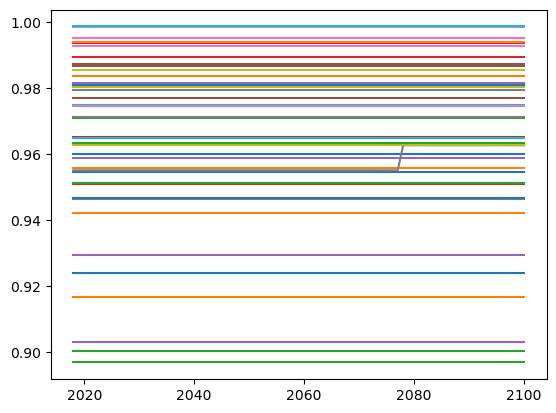

In [23]:
# Look at the secondary forest fraction
# Picked candidates, by assigning these values we can skip picking candidates
can_idx_all = np.array([3,   5,   9,  12,  15,  66,  75,  79, 161, 162, 163, 165, 166,
       168, 171, 173, 175, 255, 273, 275, 277, 280, 283, 287, 288, 289,
       290, 294, 300, 301, 303, 325, 331, 332, 470, 514, 545, 546, 547,
       550, 557, 559, 636])
yr_ax = np.arange(beg_year, end_year)
# for i in np.arange(0, nens):
for i in can_idx_all:
    plt.plot(yr_ax, arr_sec_frac[i,:])

In [12]:
# For more information about hypotherical age model under harvest rotation, see age_model in fates_func module
[hyperthetical_meanage_curve_noweight, hyperthetical_meanage_curve, hyper_age_dist] = ff.age_model(grow_years=200, run_years=150, th_age=35.0)


Text(0, 0.5, 'Mean secondary forest age (yr)')

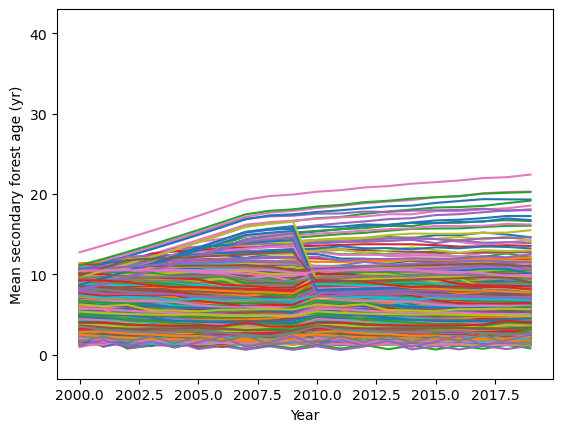

In [43]:
age_bin = patch_age_bins+1.0
age_yr = np.zeros((nens,nyr))
for iyr in np.arange(0,nyr):
    for j in np.arange(0,nens):
        for k in np.arange(0,51):
            age_yr[j,iyr] = age_yr[j,iyr] + age_bin[k] * arr_age[j,iyr,k]

# Plot annual averaged secondary forest age
for i in np.arange(0,nens):
    plt.plot(np.arange(beg_year, end_year), age_yr[i,0:nyr])

# plt.plot(np.arange(beg_year, end_year), hyperthetical_curve[0:40], 'k-')
# plt.plot(ax_yr[0:40], hyperthetical_curve_noweight[0:40], 'k--')
# plt.legend(['Candidate 1', 'Candidate 2', 'Theoretical'])
plt.ylim([-3, 43])
plt.xlabel('Year')
plt.ylabel('Mean secondary forest age (yr)')

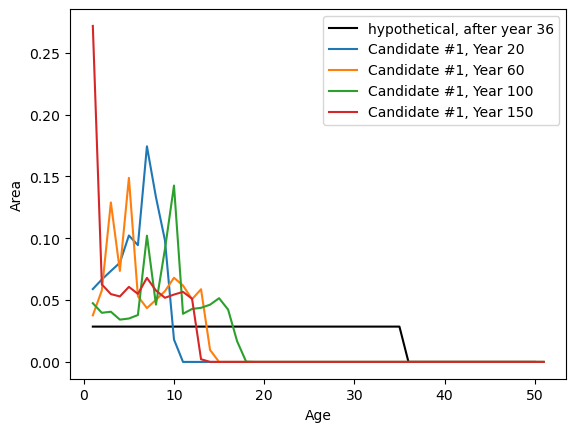

In [33]:
# Quick check of age structure from one of the candidates
plt.plot(age_bin[0:50], hyper_age_dist[:], 'k-')
plt.plot(age_bin, arr_age[9,20,:])
plt.plot(age_bin, arr_age[9,40,:])
plt.plot(age_bin, arr_age[9,60,:])
plt.plot(age_bin, arr_age[9,80,:])
plt.xlabel('Age')
plt.ylabel('Area')
# plt.ylim([-0.01, 0.26])
plt.legend(['hypothetical, after year 36', 'Candidate #1, Year 20', 'Candidate #1, Year 60', 'Candidate #1, Year 100', 'Candidate #1, Year 150'])

### Refine candidates

In [80]:
## Get candidates within reasonable range
vegc_nl_mean = np.nanmean(arr_vegc_nl[:,2013-beg_year:2019-beg_year], axis=1)
vegc_bl_mean = np.nanmean(arr_vegc_bl[:,2013-beg_year:2019-beg_year], axis=1)
gpp_mean = np.nanmean(arr_gpp[:,2013-beg_year:2019-beg_year], axis=1)
sc_mean = np.nanmean(arr_soilc[:,2013-beg_year:2019-beg_year], axis=1)

[can_idx_nl, can_idx_bl, can_idx_both, can_idx_all] = ff.refine_candidates(vegc_nl_mean, vegc_bl_mean, gpp_mean, sc_mean)

# Refine all candidates by checking if C-based harvest has been successful
can_idx_failed_list = []
for i in can_idx_all:
    if(np.any(forest_area_ha*m2_to_ha*c_to_biomass*arr_wood_product[i,2013-beg_year:2019-beg_year]/arr_wd[i]<6000.0)):
        can_idx_failed_list.append(i)
        #print(i)
can_idx_failed = np.array(can_idx_failed_list)
can_idx_refined = np.setxor1d(can_idx_all, can_idx_failed)

### Check regrowth (DDBH) of ensemble run

/tmp/ipykernel_2093755/128462828.py:2: RuntimeWarning: invalid value encountered in divide
  ddbh = np.nanmean(arr_ddbh_can_sz[:,2013-beg_year:2019-beg_year,:]/arr_num_can_sz[:,2013-beg_year:2019-beg_year,:]*100.0, axis = 1)
/tmp/ipykernel_2093755/128462828.py:2: RuntimeWarning: Mean of empty slice
  ddbh = np.nanmean(arr_ddbh_can_sz[:,2013-beg_year:2019-beg_year,:]/arr_num_can_sz[:,2013-beg_year:2019-beg_year,:]*100.0, axis = 1)
/tmp/ipykernel_2093755/128462828.py:3: RuntimeWarning: invalid value encountered in divide
  ddbh_ustory = np.nanmean(arr_ddbh_ustory_sz[:,2013-beg_year:2019-beg_year,:]/arr_num_ustory_sz[:,2013-beg_year:2019-beg_year,:]*100.0, axis = 1)
/tmp/ipykernel_2093755/128462828.py:3: RuntimeWarning: Mean of empty slice
  ddbh_ustory = np.nanmean(arr_ddbh_ustory_sz[:,2013-beg_year:2019-beg_year,:]/arr_num_ustory_sz[:,2013-beg_year:2019-beg_year,:]*100.0, axis = 1)


Text(0, 0.5, '$\\Delta$DBH ,cm yr-1')

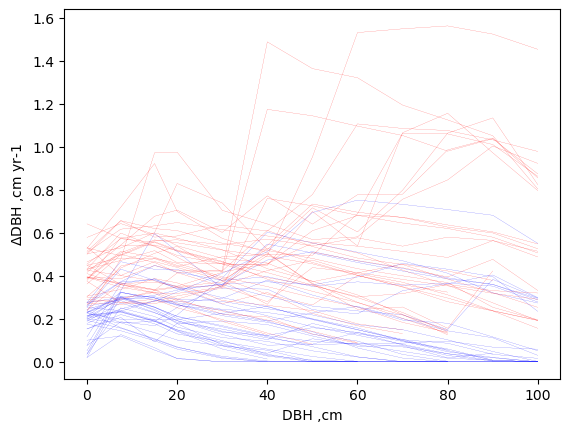

In [97]:
# Check ddbh and population
ddbh = np.nanmean(arr_ddbh_can_sz[:,2013-beg_year:2019-beg_year,:]/arr_num_can_sz[:,2013-beg_year:2019-beg_year,:]*100.0, axis = 1)
ddbh_ustory = np.nanmean(arr_ddbh_ustory_sz[:,2013-beg_year:2019-beg_year,:]/arr_num_ustory_sz[:,2013-beg_year:2019-beg_year,:]*100.0, axis = 1)

# Check population
# Need to remove the first bin
pop = np.nanmean(arr_num_can_sz[:,2013-beg_year:2019-beg_year,:], axis = 1)
pop_diff = np.nanmean(arr_num_can_sz[:,2014-beg_year:2019-beg_year,:] - arr_num_can_sz[:,2013-beg_year:2018-beg_year,:], axis = 1)

for i in can_idx_all:
    plt.plot(cohort_size_bins[0:13], ddbh[i,:], 'r-', linewidth=0.1)
    plt.plot(cohort_size_bins[0:13], ddbh_ustory[i,:], 'b-', linewidth=0.1)

plt.xlabel('DBH ,cm')
plt.ylabel('$\Delta$DBH ,cm yr-1')



In [41]:
plt.plot(cohort_size_bins[0:13], ddbh[5,:], 'r-')
plt.plot(cohort_size_bins[0:13], ddbh_ustory[5,:], 'b-')

NameError: name 'ddbh' is not defined

### Harvest rate

66
291
294
303
470
514
550


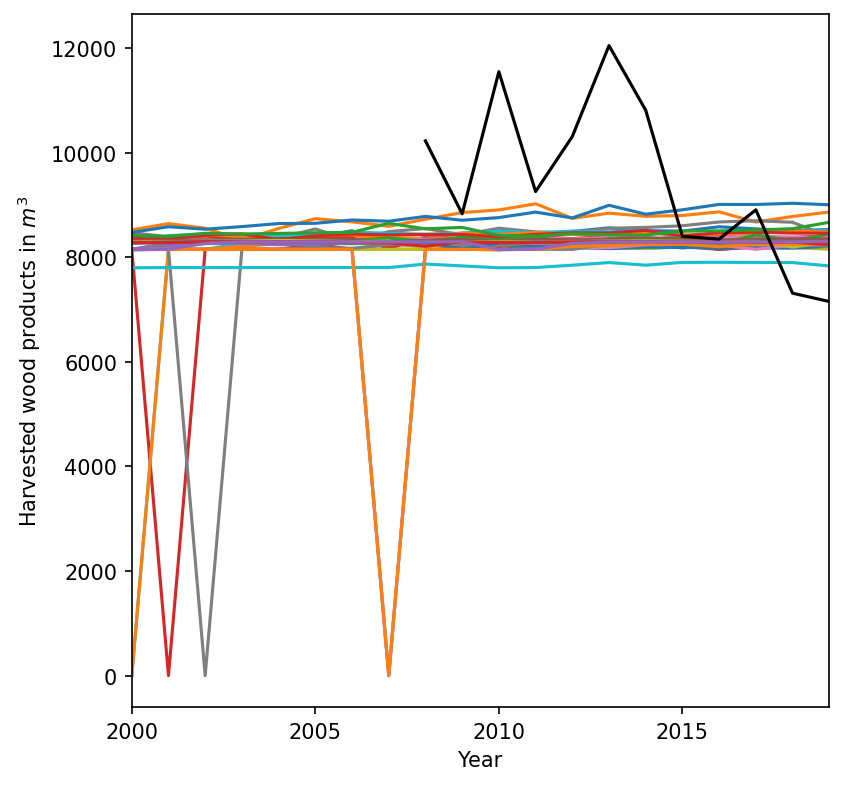

In [48]:
# Check harvest rate for verification
fig = plt.figure(figsize=(6,6), dpi=150)
# harvested wood product (m3)
# for i in np.arange(0,254):
ax_yr = np.arange(2000, 2020)

try:
    can_idx_refined
except NameError:
    can_idx_refined = np.array([  5,   9,  12,  66, 161, 162, 163, 165, 166, 168, 171, 173, 175,
       273, 275, 287, 288, 289, 290, 291, 294, 303, 325, 331, 332, 333,
       470, 514, 545, 546, 547, 550, 557, 559, 636])
    
# for i in np.arange(0,254):
for i in can_idx_refined:
    plt.plot(ax_yr, forest_area_ha*m2_to_ha*c_to_biomass*arr_wood_product[i,ax_yr-beg_year]/arr_wd[i])
    if(np.any(forest_area_ha*m2_to_ha*c_to_biomass*arr_wood_product[i,ax_yr-beg_year]/arr_wd[i]<6000.0)):
        print(i)

# Put the recorded harvested C here.
rec_yr = np.arange(2008,2028)
rec_hrvv = np.array([10228.48, 8833.41, 11552.41, 9258.62, 10311.47, 12051.44, 10814.60, 
                   8400.84, 8349.92, 8910.00, 7314.93, 7155.24, 6468.95, 5719.50, 
                   6866.16, 8509.43, 9922.54, 9749.23, 9593.83, 8741.28])
plt.plot(rec_yr, rec_hrvv, 'k-')

# plt.ylim([0, 15000])
plt.xticks([2000, 2005, 2010, 2015])
plt.xlim([2000, 2019])
plt.xlabel('Year')
plt.ylabel('Harvested wood products in $m^3$')
plt.savefig('c_based_hrv.png')

### Diagnose regrowth rate variability

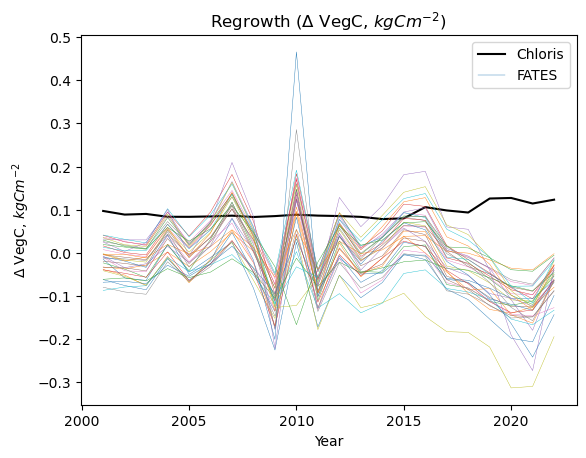

In [15]:
# Check growth rate against benchmark data
chloris = np.array([89.837, 90.806, 91.691, 92.591, 93.425, 94.258, 95.100, 95.960, 96.789, 97.639, 98.521, 99.382, 100.233, 101.065, 101.846, 102.643, 103.701, 104.682, 105.615, 106.873, 108.144, 109.286, 110.517]) * 0.1
g_rate = 0.6*(arr_vegc_nl_mean[:,1:nyr]+arr_vegc_bl_mean[:,1:nyr])-0.6*(arr_vegc_nl_mean[:,0:nyr-1]+arr_vegc_bl_mean[:,0:nyr-1])
plt.plot(np.arange(2001,2023), chloris[1:23]-chloris[0:22], 'k-')
cnt = 0
for i in can_idx_refined:
# for i in np.arange(0,nens):
    if(cnt == 0):
        plt.plot(ax_yr[1:nyr], g_rate[i,:], linewidth=0.3)
    else:
        plt.plot(ax_yr[1:nyr], g_rate[i,:], linewidth=0.3, label='_nolegend_')   
    cnt += 1

# The large decrease is related to member 470
# Following members have failed harvest 3, 66, 277, 283, 294, 303, 470, 514, 550
# The refined candidates are
can_idx_refined = np.setxor1d(can_idx_all, [3, 66, 277, 283, 294, 303, 470, 514, 550])
plt.title('Regrowth ($\Delta$ VegC, $kgC m^{-2}$)')
plt.ylabel('$\Delta$ VegC, $kgC m^{-2}$')
plt.xlabel('Year')
plt.legend(['Chloris', 'FATES'])

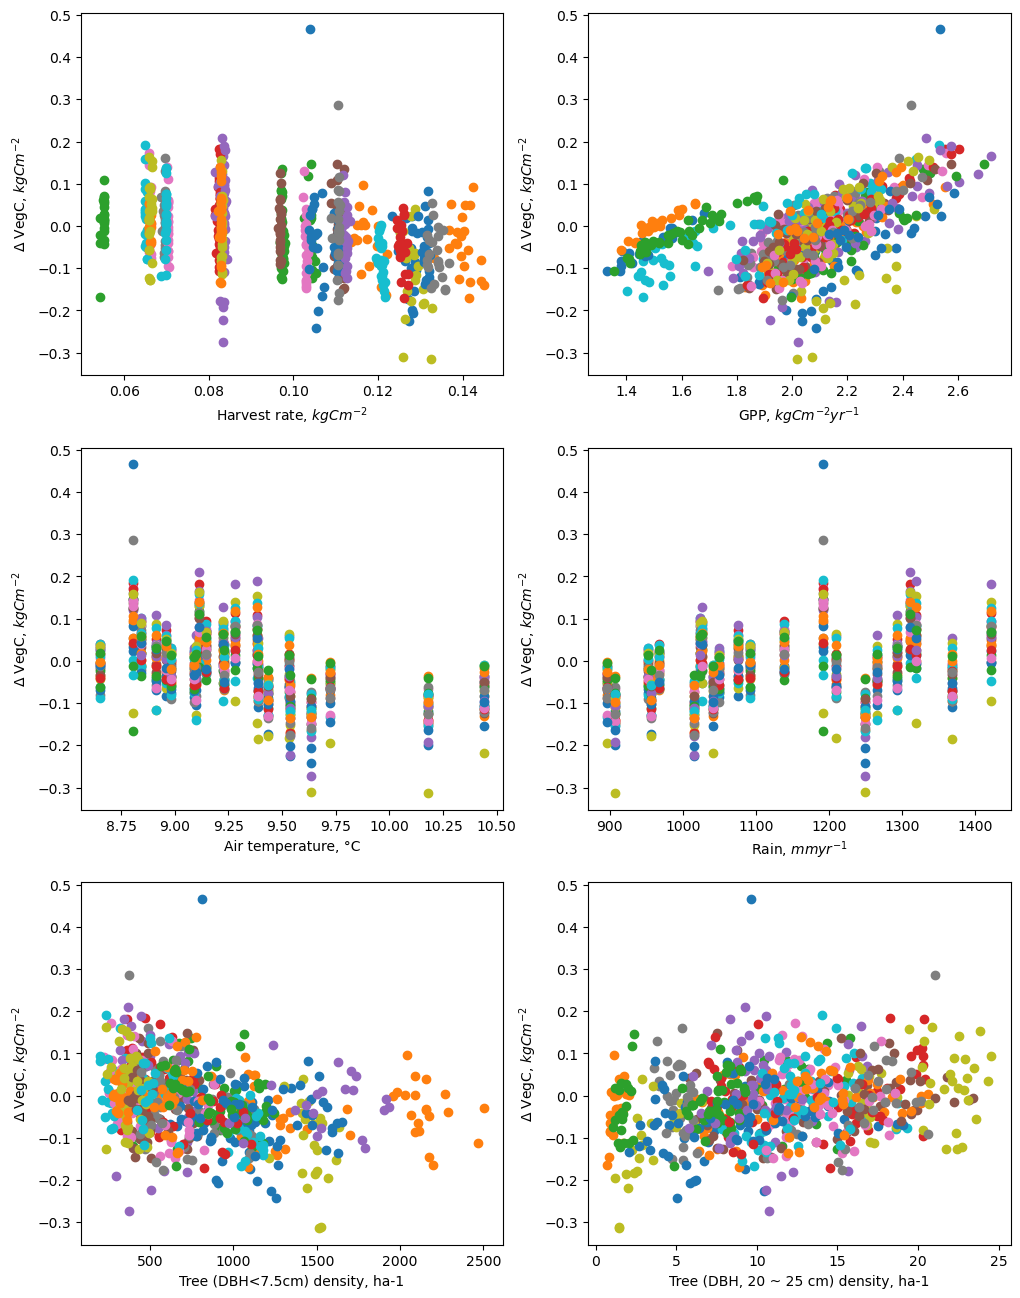

In [16]:
# Regrowth correlation to multiple factors, first look 
fig, axs = plt.subplots(3, 2)
fig.set_figheight(16)
fig.set_figwidth(12)

for i in np.arange(0, 3):
    for j in np.arange(0, 2):
        if (i == 0):
            if (j == 0):
                for iens in can_idx_refined:
                    axs[i, j].scatter(arr_wood_product_mean[iens,1:nyr], g_rate[iens,:])
                axs[i, j].set_xlabel('Harvest rate, $kgC m^{-2}$')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')
            if (j == 1):
                for iens in can_idx_refined:
                    axs[i, j].scatter(arr_gpp_nl_mean[iens,1:nyr]+arr_gpp_bl_mean[iens,1:nyr], g_rate[iens,:])
                axs[i, j].set_xlabel('GPP, $kgC m^{-2} yr^{-1}$')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')
        if (i == 1):
            if (j == 0):
                for iens in can_idx_refined:
                    axs[i, j].scatter(arr_tbot_mean[iens,1:nyr]-273.16, g_rate[iens,:])
                axs[i, j].set_xlabel('Air temperature, °C')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')
            if (j == 1):
                for iens in can_idx_refined:
                    axs[i, j].scatter((arr_rain_mean[iens,1:nyr]+arr_snow_mean[iens,1:nyr])*3600*24*365, g_rate[iens,:])
                axs[i, j].set_xlabel('Rain, $mm yr^{-1}$')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')
        if (i == 2):
            if (j == 0):
                for iens in can_idx_refined:
                    axs[i, j].scatter(arr_num_can_sz_mean[iens,1:nyr,0]*1e4, g_rate[iens,:])
                axs[i, j].set_xlabel('Tree (DBH<7.5cm) density, ha-1')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')
            if (j == 1):
                for iens in can_idx_refined:
                    axs[i, j].scatter(arr_num_can_sz_mean[iens,1:nyr,5]*1e4, g_rate[iens,:])
                axs[i, j].set_xlabel('Tree (DBH, 20 ~ 25 cm) density, ha-1')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')
                
#fig.suptitle('Needleleaf vegetation C, each subplot represent 1 set of NF parameter', fontsize=20)
# fig.tight_layout()
# plt.show()

# harvest rate


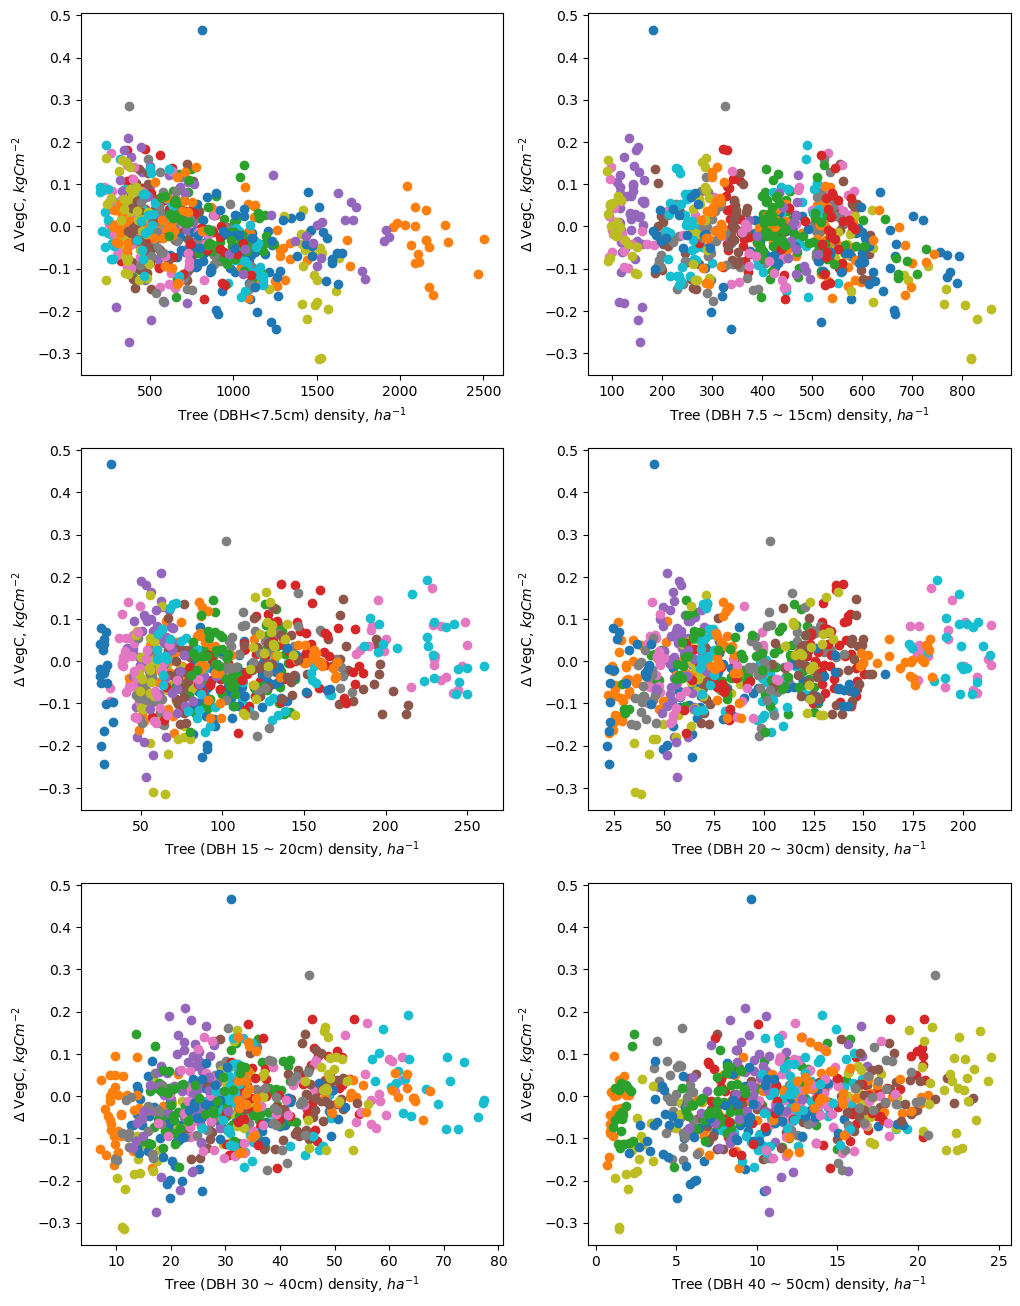

In [17]:
# Regrowth correlation to trees density with different size 
fig, axs = plt.subplots(3, 2)
fig.set_figheight(16)
fig.set_figwidth(12)

for i in np.arange(0, 3):
    for j in np.arange(0, 2):
        if (i == 0):
            if (j == 0):
                for iens in can_idx_refined:
                    axs[i, j].scatter(arr_num_can_sz_mean[iens,1:nyr,0]*1e4, g_rate[iens,:])
                axs[i, j].set_xlabel('Tree (DBH<7.5cm) density, $ha^{-1}$')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')
            if (j == 1):
                for iens in can_idx_refined:
                    axs[i, j].scatter(arr_num_can_sz_mean[iens,1:nyr,1]*1e4, g_rate[iens,:])
                axs[i, j].set_xlabel('Tree (DBH 7.5 ~ 15cm) density, $ha^{-1}$')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')
        if (i == 1):
            if (j == 0):
                for iens in can_idx_refined:
                    axs[i, j].scatter(arr_num_can_sz_mean[iens,1:nyr,2]*1e4, g_rate[iens,:])
                axs[i, j].set_xlabel('Tree (DBH 15 ~ 20cm) density, $ha^{-1}$')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')
            if (j == 1):
                for iens in can_idx_refined:
                    axs[i, j].scatter(arr_num_can_sz_mean[iens,1:nyr,3]*1e4, g_rate[iens,:])
                axs[i, j].set_xlabel('Tree (DBH 20 ~ 30cm) density, $ha^{-1}$')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')
        if (i == 2):
            if (j == 0):
                for iens in can_idx_refined:
                    axs[i, j].scatter(arr_num_can_sz_mean[iens,1:nyr,4]*1e4, g_rate[iens,:])
                axs[i, j].set_xlabel('Tree (DBH 30 ~ 40cm) density, $ha^{-1}$')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')
            if (j == 1):
                for iens in can_idx_refined:
                    axs[i, j].scatter(arr_num_can_sz_mean[iens,1:nyr,5]*1e4, g_rate[iens,:])
                axs[i, j].set_xlabel('Tree (DBH 40 ~ 50cm) density, $ha^{-1}$')
                axs[i, j].set_ylabel('$\Delta$ VegC, $kgC m^{-2}$')

/tmp/ipykernel_847305/470742957.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(cohort_size_bins, 100.0*np.nanmean(arr_ddbh_can_sz[i,0:240,:,0]/arr_num_can_sz[i,0:240,:,0], axis=0), linewidth=0.3)
/tmp/ipykernel_847305/470742957.py:5: RuntimeWarning: Mean of empty slice
  plt.plot(cohort_size_bins, 100.0*np.nanmean(arr_ddbh_can_sz[i,0:240,:,0]/arr_num_can_sz[i,0:240,:,0], axis=0), linewidth=0.3)


Text(0, 0.5, '$\\Delta DBH$ in cm yr-1')

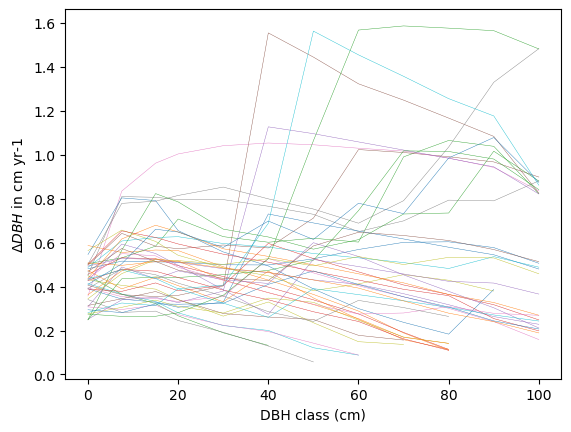

In [58]:
# Plot ddbh time series from new candidates
ax_yr = np.arange(2000, 2020)
for i in can_idx_all:
# for i in np.arange(0,nens):
    plt.plot(cohort_size_bins, 100.0*np.nanmean(arr_ddbh_can_sz[i,0:240,:,0]/arr_num_can_sz[i,0:240,:,0], axis=0), linewidth=0.3)
# plt.ylim([0, 20])
plt.xlabel('DBH class (cm)')
plt.ylabel('$\Delta DBH$ in cm yr-1')


In [29]:
# Compare to the obs and select good candidates
planet_obs = np.array([93.14, 92.95, 103.46, 100.74, 110.51])*0.1
bias_from_obs = []
for i in np.arange(0,254):
    bias_from_obs.append(np.nansum(np.abs(0.6*(arr_vegc_nl_mean[i,8:13]+arr_vegc_bl_mean[i,8:13]) - planet_obs)))

np.argsort(bias_from_obs)

ValueError: operands could not be broadcast together with shapes (0,) (5,) 

In [88]:
can_idx_all

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

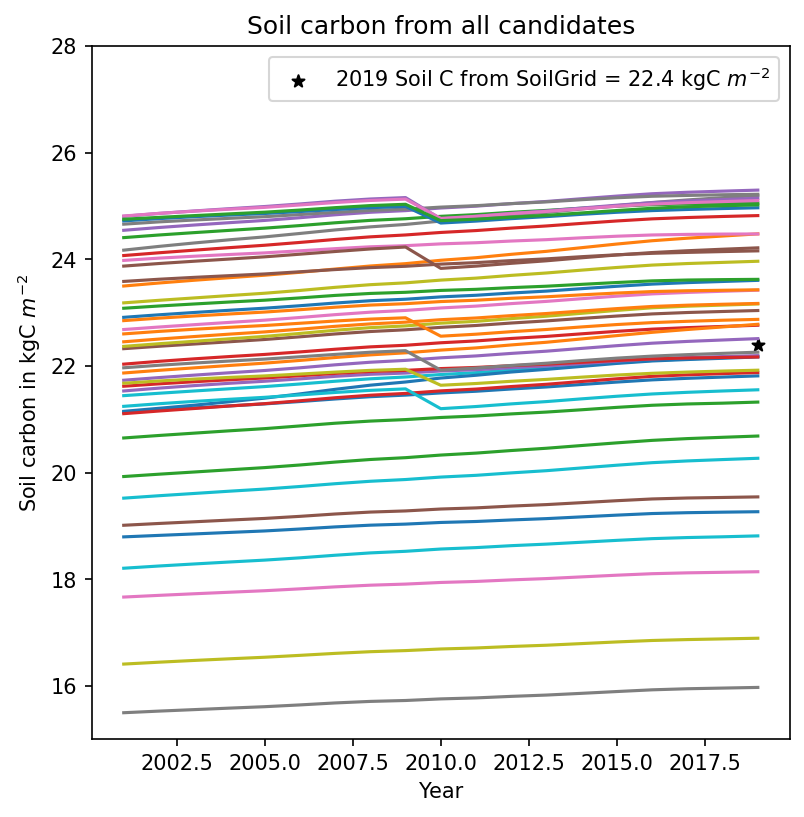

In [12]:
# Plot vegc time series from new candidates
# for i in np.arange(0,254):
fig = plt.figure(figsize=(6,6), dpi=150)
for i in can_idx_all:
    plt.plot(ax_yr[1:nyr], arr_soilc_mean[i,1:nyr]-4, label='_nolegend_')
plt.ylim([15, 28])
plt.xlabel('Year')
plt.ylabel('Soil carbon in kgC $m^{-2}$')
plt.scatter(([2019]), ([22.4]), color='k', marker='*')
plt.legend(['2019 Soil C from SoilGrid = 22.4 kgC $m^{-2}$'])
plt.title('Soil carbon from all candidates')
plt.savefig('soilc.png')

In [167]:
arr_wood_product_mean[5,ax_yr-beg_year]/arr_wd[5]

array([8.63393183e-07, 7.69977446e-07, 6.77155741e-07, 6.54949725e-07,
       3.70186002e-07, 6.59842577e-07, 6.63793013e-07, 6.68402463e-07,
       6.56279140e-07, 5.27577417e-07, 6.63729426e-07, 5.62752449e-07,
       7.93673723e-07, 6.59644244e-07, 1.29134071e-06, 3.41913034e-07,
       2.86781691e-07, 7.51078372e-07, 4.79374615e-07, 2.99113443e-07])

In [165]:
c_to_biomass

2.0

ValueError: x and y must have same first dimension, but have shapes (82,) and (20,)

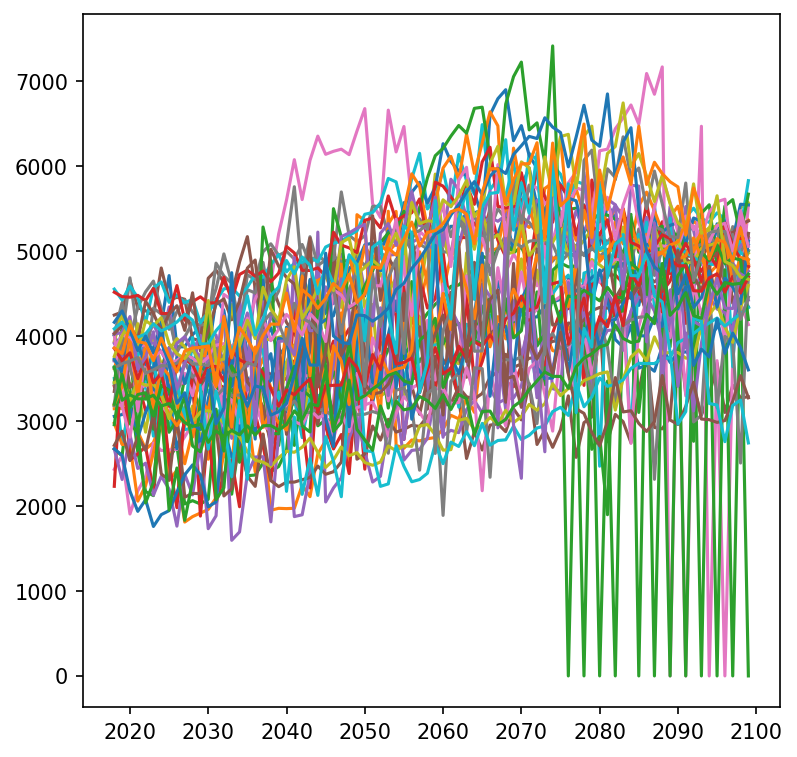

In [22]:
fig = plt.figure(figsize=(6,6), dpi=150)
# harvested wood product (m3)
# for i in np.arange(0,254):
ax_yr = np.arange(2018, 2100)
# for i in np.arange(0,254):
for i in can_idx_all:
    plt.plot(ax_yr, forest_area_ha*m2_to_ha*c_to_biomass*arr_wood_product_mean[i,ax_yr-beg_year]/arr_wd[i])

# Put the recorded harvested C here.
rec_yr = np.arange(2018,2100)
rec_hrvv = np.array([10228.48, 8833.41, 11552.41, 9258.62, 10311.47, 12051.44, 10814.60, 
                   8400.84, 8349.92, 8910.00, 7314.93, 7155.24, 6468.95, 5719.50, 
                   6866.16, 8509.43, 9922.54, 9749.23, 9593.83, 8741.28])
plt.plot(rec_yr, rec_hrvv, 'k-')

# plt.ylim([0, 15000])
plt.xticks([2000, 2005, 2010, 2015])
plt.xlim([2000, 2019])
plt.xlabel('Year')
plt.ylabel('Harvested wood products in $m^3$')
plt.savefig('a_based_hrv.png')


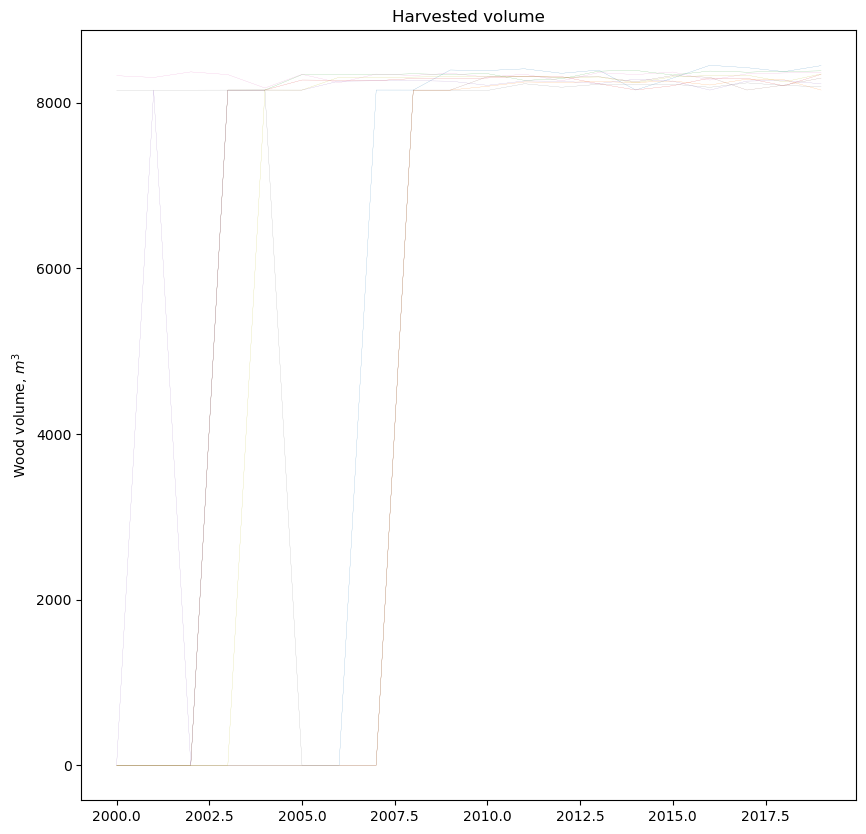

In [38]:
# Comparison of harvested forest volume against obs
# can_idx_all = np.arange(0,254)
fig1, (f1ax0) = plt.subplots(nrows=1, figsize=(10, 10))
# for i in [0]:
    # sh1_v = forest_area_ha * (vh1_ts[i,121:179] + sh1_ts[i,121:179]) / (arr_wd[i]*0.5)
    # f1ax0.plot(np.arange(2000,2015),sh1_v[30:45], 'k-', linewidth=1.0)
# for i in np.arange(0,254):
for i in can_idx_all:
    f1ax0.plot(np.arange(2000,2020), forest_area_ha*m2_to_ha*c_to_biomass*arr_wood_product_mean[i,2000-beg_year:2020-beg_year]/arr_wd[i], linewidth=0.1)

# f1ax0.set_xlim([2020, 2028])
f1ax0.set_title(r'Harvested volume')
#f1ax0.set_xlabel('Year')
f1ax0.set_ylabel('Wood volume, $m^3$')


plt.savefig('harv_c.png')

In [30]:
bias = []
for i in np.arange(0,254):
    calc_hrvv = forest_area_ha*m2_to_ha*c_to_biomass*arr_wood_product_mean[i,0:nyr]/arr_wd[i]
    bias.append(np.nansum(np.abs(calc_hrvv[8:15] - rec_hrvv[0:7])))
bias_array = np.array(bias)
minidx = np.argmin(bias_array)

### Comparison to on-site and RS-based tree measurement

In [13]:
# Open on-site tree measurements
df_full  = pd.read_csv('Tree_measurements.csv', low_memory=False)
# Get DBH vs. biomass correlation
pft_id = np.array(df_full.Species_ID)
dbh_obs = np.array(df_full.Final_DBH_cm)
ba_obs = np.array(df_full.Basal_Area)
hi_obs = np.array(df_full.Final_Height_m)
vegc_obs = np.array(df_full.Biomass_kg)*0.5

nl_dbh_obs = dbh_obs[pft_id<=2]
nl_vegc_obs = vegc_obs[pft_id<=2]
nl_hi_obs = hi_obs[pft_id<=2]
bl_dbh_obs = dbh_obs[pft_id>2]
bl_vegc_obs = vegc_obs[pft_id>2]
bl_hi_obs = hi_obs[pft_id>2]

fir_dbh_obs = dbh_obs[pft_id==1]
fir_vegc_obs = vegc_obs[pft_id==1]
fir_hi_obs = hi_obs[pft_id==1]
pine_dbh_obs = dbh_obs[pft_id==2]
pine_vegc_obs = vegc_obs[pft_id==2]
pine_hi_obs = hi_obs[pft_id==2]
alder_dbh_obs = dbh_obs[pft_id==3]
alder_vegc_obs = vegc_obs[pft_id==3]
alder_hi_obs = hi_obs[pft_id==3]
oak_dbh_obs = dbh_obs[pft_id==4]
oak_vegc_obs = vegc_obs[pft_id==4]
oak_hi_obs = hi_obs[pft_id==4]

# check the barplot of binned DBH
nagebins = len(patch_age_bins)
nsizebins = len(cohort_size_bins)

## because the bin edges read in define the lower edges, add a last index to each to
## represent the upper edge of the distribution (even though there isn't one, really)
# time = np.append(time,time[ntim-1]+31.0)
patch_age_bins = np.append(patch_age_bins,patch_age_bins[nagebins-1]*1.5)
cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[nsizebins-1]*1.5)
cohort_size_bins = np.array([0.00000000e+00, 7.50000000e+00, 1.50000000e+01,
                   2.00000000e+01, 3.00000000e+01, 4.00000000e+01,
                   5.00000000e+01, 6.00000000e+01, 7.00000000e+01,
                   8.00000000e+01, 9.00000000e+01, 1.00000000e+02,
                   110, 120])

# divide into size bins
sizebins = [7.5, 15, 20, 30, 40, 50, 60, 70]

# Nb divide by X to get it per ha
binned = pd.cut(dbh_obs, bins=sizebins)
bin_counts_all = binned.value_counts()
obs_sz_frac = bin_counts_all.values/np.float32(np.sum(bin_counts_all.values))

In [14]:
# Area of RS product, in m2
rs_crown_area = 5711200
rs_area = 8117850

# Open tree measurements from RS products
df_rs  = pd.read_csv('SR_RS_with_cluster.csv', low_memory=False)
# Get DBH vs. biomass correlation
lon_rs = np.array(df_rs.lon)
lat_rs = np.array(df_rs.lat)
crown_rs = np.array(df_rs.crown)
biomass_rs = np.array(df_rs.biomass)*0.5
height_rs = np.array(df_rs.height)
# 0 - Pine, 1 - Oak?
cluster_rs = np.array(df_rs.Cluster)

# Since DBH is correlated to height one-by-one, We bin the height and check the population distribution from FATES
#height_bin = np.arange(5,85,5)
# Ignore plant height below 10m
height_bin = np.arange(5,130,5)
binned_n_rs = np.zeros(np.shape(height_bin))
frac_n_rs = np.zeros(np.shape(height_bin))

# Get the population distribution
for i in height_rs:
    idx = int(i/5) - 1
    if idx>=0:
        binned_n_rs[idx] = binned_n_rs[idx] + 1
frac_n_rs =  binned_n_rs/np.nansum(binned_n_rs)

# # check the barplot of binned DBH
# nagebins = len(patch_age_bins)
# nsizebins = len(cohort_size_bins)

## because the bin edges read in define the lower edges, add a last index to each to
## represent the upper edge of the distribution (even though there isn't one, really)
# time = np.append(time,time[ntim-1]+31.0)
# patch_age_bins = np.append(patch_age_bins,patch_age_bins[nagebins-1]*1.5)
# cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[nsizebins-1]*1.5)
# cohort_size_bins = np.array([0.00000000e+00, 7.50000000e+00, 1.50000000e+01,
#                    2.00000000e+01, 3.00000000e+01, 4.00000000e+01,
#                    5.00000000e+01, 6.00000000e+01, 7.00000000e+01,
#                    8.00000000e+01, 9.00000000e+01, 1.00000000e+02,
#                    110, 120])

# # divide into size bins
# sizebins = [7.5, 15, 20, 30, 40, 50, 60, 70]

# # Nb divide by X to get it per ha
# binned = pd.cut(dbh_obs, bins=sizebins)
# bin_counts_all = binned.value_counts()
# obs_sz_frac = bin_counts_all.values/np.float32(np.sum(bin_counts_all.values))

In [34]:
start = tm.time()
block_n = 3
block_ens = [210, 210, 218]

block_path = ['/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_1_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/', \
              '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_2_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/', \
              '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_3_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/']
block_prefix = ['fates_uav_mxbreeding638_1_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_',\
               'fates_uav_mxbreeding638_2_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_', \
               'fates_uav_mxbreeding638_3_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_']
fyear = [2020]

[arr_can, arr_cnplant, arr_cheight, arr_clai, arr_ccarea, arr_cleafc, arr_cfnrtc, arr_csapwc, arr_cstorc, arr_creproc, arr_cstruc, \
 arr_cdbh, arr_cddbh, arr_cgpp, arr_cnpp, arr_cpft, arr_cagcwd, arr_cbgcwd, arr_cleaflit, arr_crootlit, arr_abg_c, arr_hrv_c] = \
ff.read_fatesmrv_restart(block_n, block_ens, fyear, block_path, block_prefix)

end = tm.time()
print('Time elapsed: ', end - start)

Time elapsed:  28.606924295425415


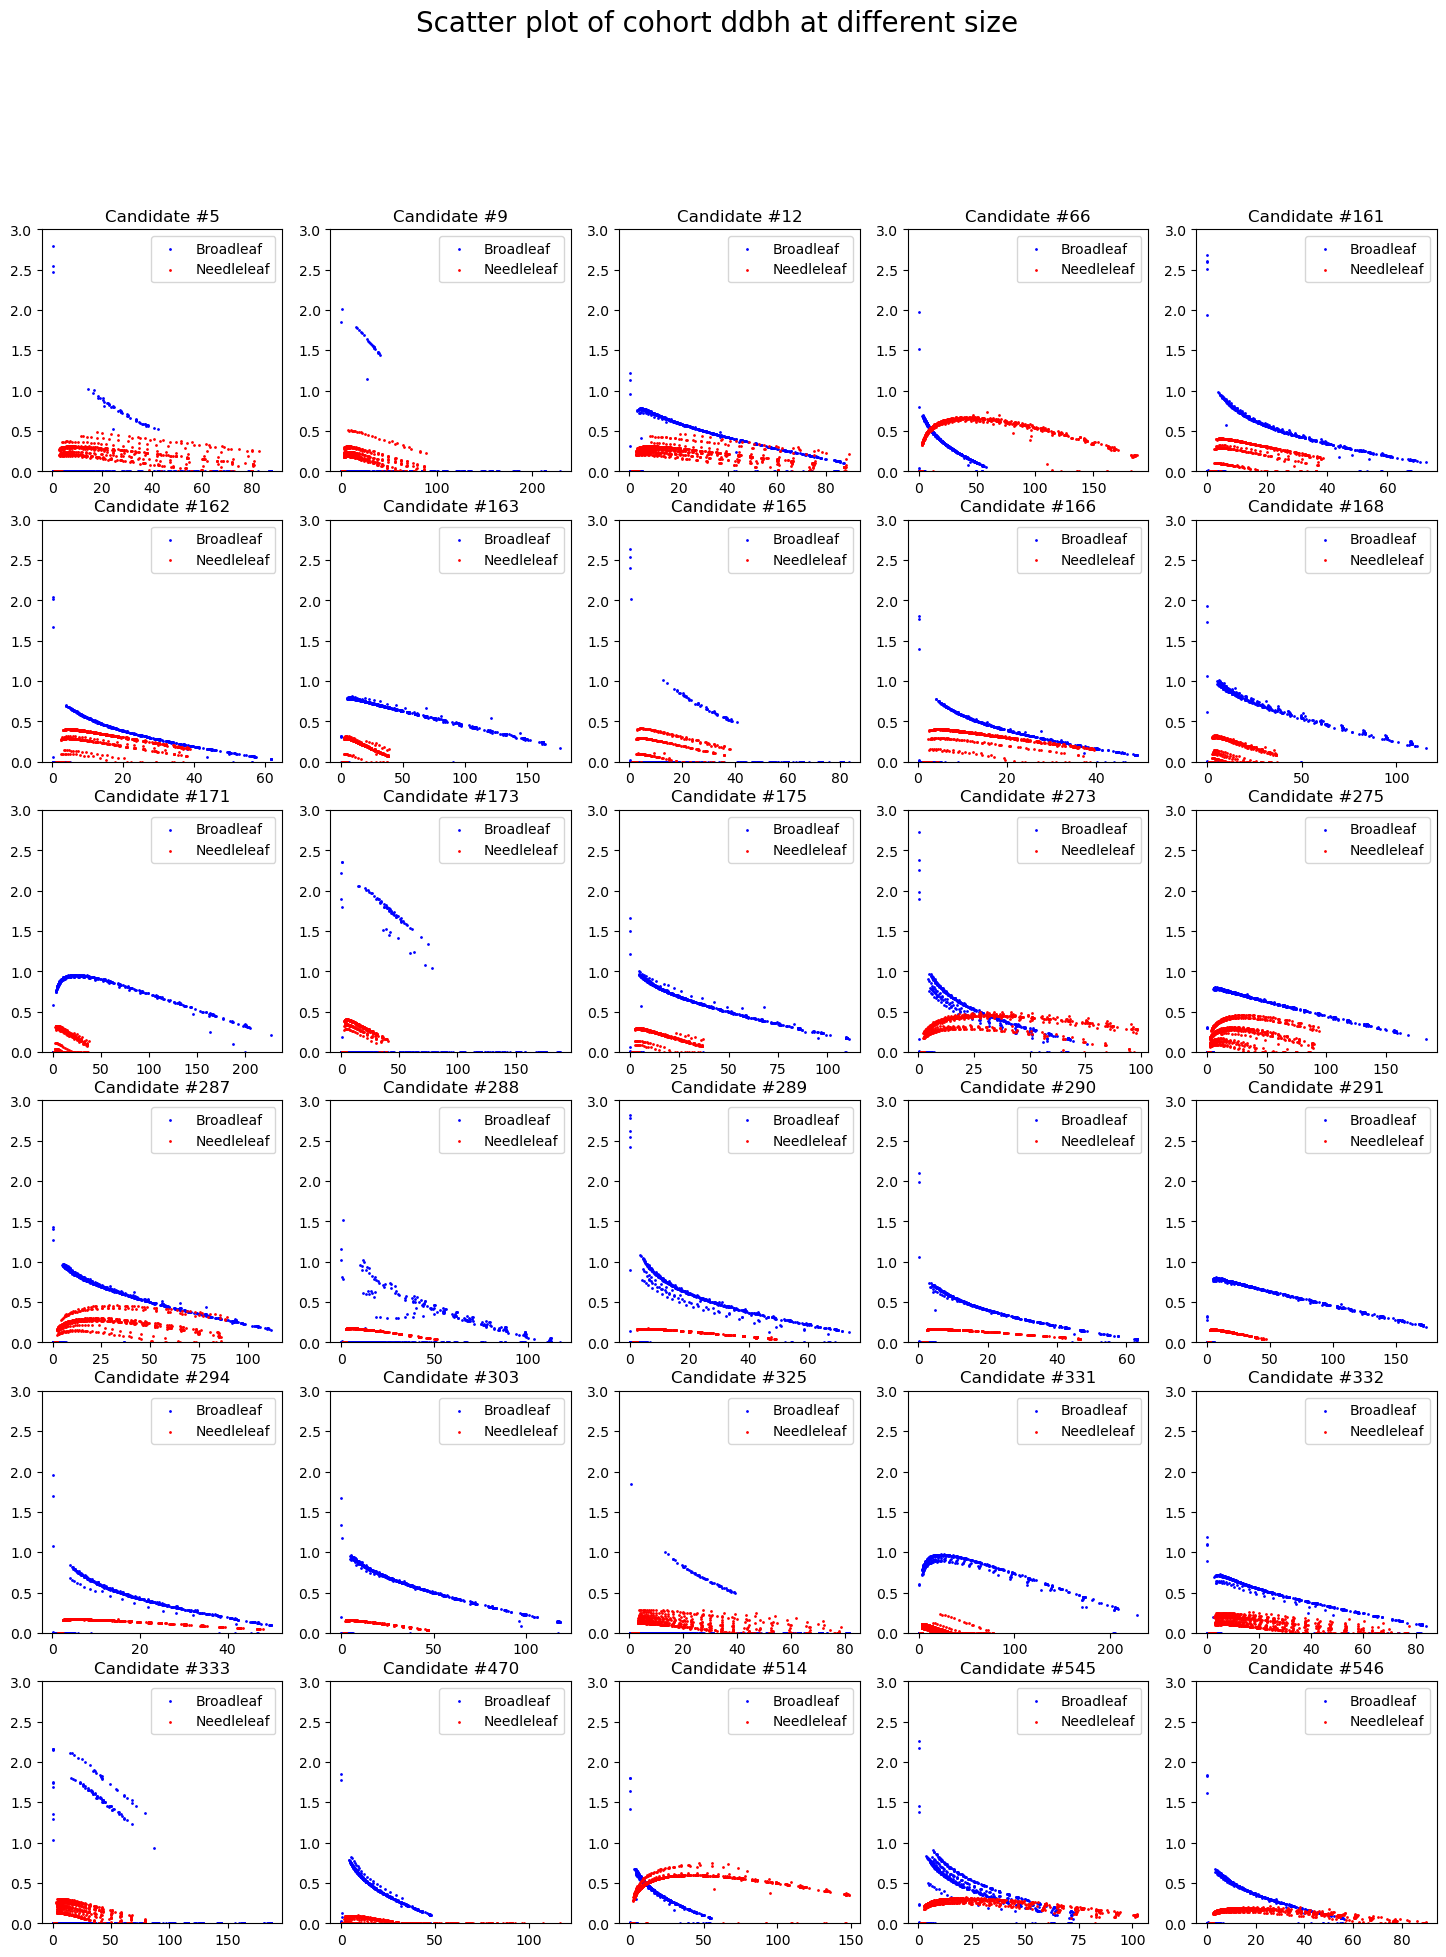

In [35]:
# Check ddbh for all candidates
# Make a scatter plot with all candidates
try:
    can_idx_refined
except NameError:
    can_idx_refined = np.array([  5,   9,  12,  66, 161, 162, 163, 165, 166, 168, 171, 173, 175,
       273, 275, 287, 288, 289, 290, 291, 294, 303, 325, 331, 332, 333,
       470, 514, 545, 546, 547, 550, 557, 559, 636])
fig, axs = plt.subplots(6, 5)
fig.set_figheight(22)
fig.set_figwidth(18)

for i in np.arange(0, 6):
    for j in np.arange(0, 5):
        iens = can_idx_refined[i*5+j]
        arr_cdbh_sel = arr_cdbh[iens,0,:]
        arr_cddbh_sel = arr_cddbh[iens,0,:]
        arr_can_sel = arr_can[iens,0,:]
        arr_cpft_sel = arr_cpft[iens,0,:]
        picked_idx = ((arr_can_sel == 1) & (arr_cpft_sel == 1))
        axs[i, j].scatter(arr_cdbh_sel[picked_idx], arr_cddbh_sel[picked_idx], color='b', s = 1)
        picked_idx = ((arr_can_sel == 1) & (arr_cpft_sel == 2))
        axs[i, j].scatter(arr_cdbh_sel[picked_idx], arr_cddbh_sel[picked_idx], color='r', s = 1)
        axs[i, j].legend(['Broadleaf', 'Needleleaf'])
        axs[i, j].set_ylim([0,3])
        axs[i, j].set_title('Candidate #'+str(iens))

fig.suptitle('Scatter plot of cohort ddbh at different size', fontsize=20)
# fig.tight_layout()
plt.show()

635
740
865
1161
1436


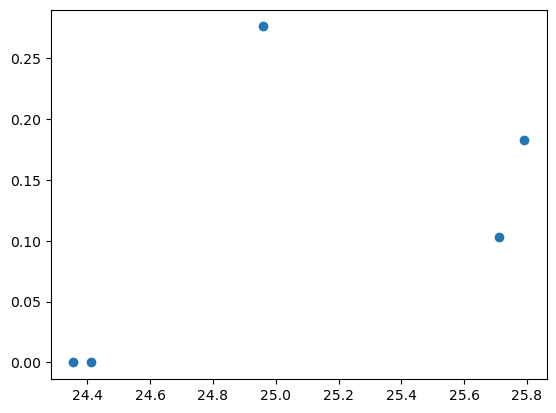

In [205]:
arr_cdbh_sel = arr_cdbh[470,0,:]
arr_cddbh_sel = arr_cddbh[470,0,:]
arr_can_sel = arr_can[470,0,:]
arr_cpft_sel = arr_cpft[470,0,:]
picked_idx = (arr_can_sel == 1) & (arr_cdbh_sel<26) & (arr_cdbh_sel>24)
plt.scatter(arr_cdbh_sel[picked_idx], arr_cddbh_sel[picked_idx])
# plt.ylim([0,3])
for ico in np.arange(0,6400):
    if(picked_idx[ico]):
        print(ico)

In [15]:
arr_cddbh[470,0,635]

0.0

In [16]:
arr_cddbh[470,0,1436]

0.2762351892364734

In [17]:
arr_cdbh[470,0,635]

24.35492056693491

In [18]:
arr_cdbh[470,0,1436]

24.96001431075985

In [207]:
arr_cdbh_sel[picked_idx]

array([24.35492057, 24.41254593, 25.79154959, 25.71155719, 24.96001431])

In [206]:
arr_cpft_sel[picked_idx]

array([2, 2, 1, 2, 2], dtype=int32)

(0.0, 3.0)

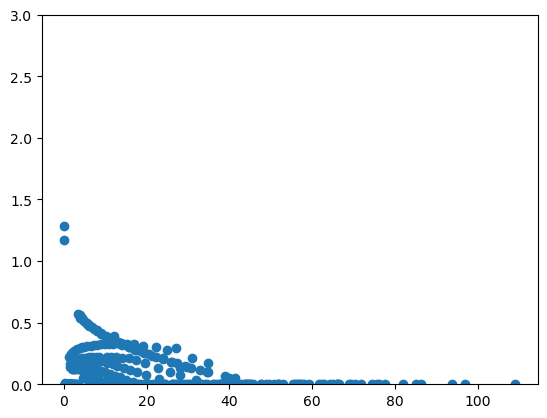

In [196]:
arr_cdbh_sel = arr_cdbh[470,0,:]
arr_cddbh_sel = arr_cddbh[470,0,:]
arr_can_sel = arr_can[470,0,:]
plt.scatter(arr_cdbh_sel[arr_can_sel == 1], arr_cddbh_sel[arr_can_sel == 1])
plt.ylim([0,3])

In [158]:
# calculate averaged ddbh
#for iens in np.arange(0, 638):
iens = 275
cohort_size_bins_lb = cohort_size_bins[0:12]
cohort_size_bins_ub = cohort_size_bins[1:13]
arr_cddbh_binned = np.zeros((13))
arr_pop_binned = np.zeros((13))
for ico in np.arange(0, 6400):
    if(arr_can[iens,0,ico] == 1):
        for isz in np.arange(0,13):
            if(isz<12):
                if(arr_cdbh[iens,0,ico]>cohort_size_bins_lb[isz] and arr_cdbh[iens,0,ico]>cohort_size_bins_lb[isz]<cohort_size_bins_ub[isz]):
                    arr_cddbh_binned[isz] = arr_cddbh_binned[isz] + arr_cddbh[iens,0,ico]*arr_cnplant[iens,0,ico]
                    arr_pop_binned[isz] = arr_pop_binned[isz] + arr_cnplant[iens,0,ico]
            else:
                if(arr_cdbh[iens,0,ico]>cohort_size_bins_lb[isz-1]):
                    arr_cddbh_binned[isz] = arr_cddbh_binned[isz] + arr_cddbh[iens,0,ico]*arr_cnplant[iens,0,ico]
                    arr_pop_binned[isz] = arr_pop_binned[isz] + arr_cnplant[iens,0,ico]
if(arr_cddbh_binned[6]/arr_pop_binned[6] > arr_cddbh_binned[2]/arr_pop_binned[2]):
    print(iens)


/tmp/ipykernel_2093755/1477924382.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  arr_cddbh_binned[isz] = arr_cddbh_binned[isz] + arr_cddbh[iens,0,ico]*arr_cnplant[iens,0,ico]


/tmp/ipykernel_2093755/3708984499.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(cohort_size_bins, arr_cddbh_binned/arr_pop_binned)


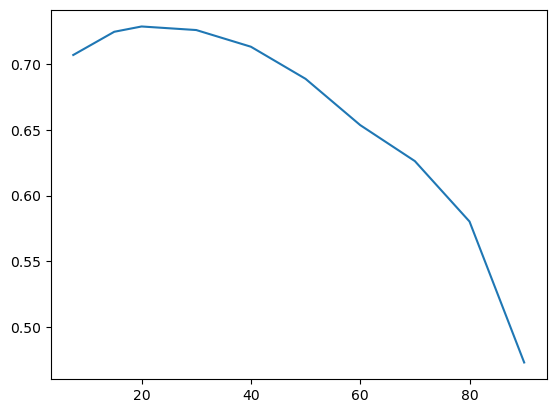

In [159]:
plt.plot(cohort_size_bins, arr_cddbh_binned/arr_pop_binned)
# plt.ylim([0,2])

(0.0, 0.7)

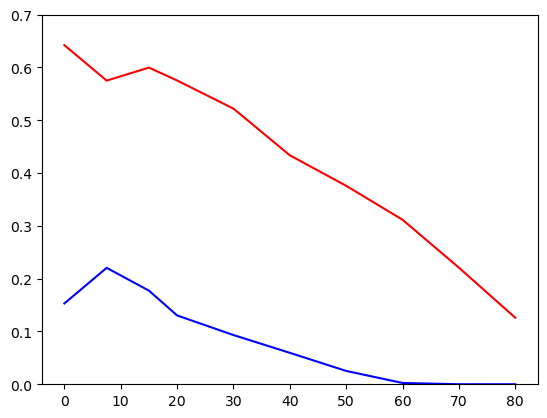

In [102]:
plt.plot(cohort_size_bins[0:13], ddbh[,:], 'r-')
plt.plot(cohort_size_bins[0:13], ddbh_ustory[5,:], 'b-')
plt.ylim([0,0.7])

In [54]:
np.where(arr_cddbh[66,0,:]>5)

(array([   4, 1304, 1705, 2006, 2204, 3506]),)

In [16]:
np.where(arr_cdbh[66,0,:]<0.2)

(array([   0,    1,    2, ..., 6397, 6398, 6399]),)

In [51]:
arr_cddbh[66,0,2]

1.2415286524364413

In [52]:
arr_cddbh[66,0,1304]

30.895902533301285

In [41]:
arr_cdbh[66,0,2]

0.11862856658127012

In [43]:
arr_cdbh[66,0,1304]

0.1960472307505989

In [26]:
arr_cnplant[66,0,2]

0.027876569955751114

In [27]:
arr_cnplant[66,0,2]

0.027876569955751114

In [32]:
arr_cnpp[66,0,2]

3.400059909826655e-05

In [5]:
arr_cnpp[66,0,1304]

4.106399051298345e-05

In [38]:
arr_clai[66,0,2]

0.4063309431337484

In [37]:
arr_clai[66,0,1304]

0.22139999149595233

In [46]:
arr_cnplant[66,0,2]

0.027876569955751114

In [45]:
arr_cnplant[66,0,1304]

14.550916153948924

In [54]:
arr_ccarea[66,0,1304]

3.7360339738644615

In [55]:
arr_cheight[66,0,1304]

1.620482849013145

Text(0.5, 0, 'DBH (cm)')

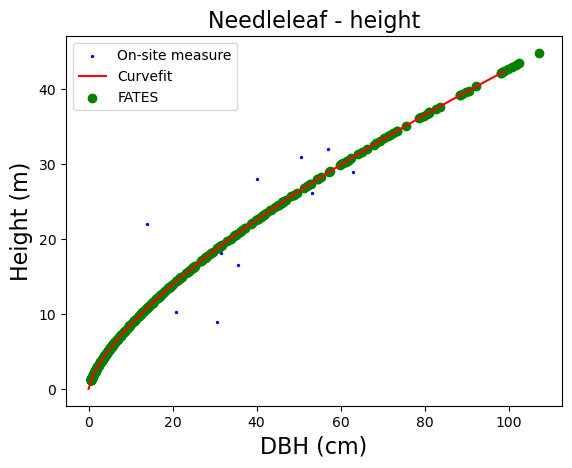

In [37]:
# ens_num: the picked ensemble member to show here
ens_num=40
time_slice=0

# Obtain allometric correlation from Tree measurements
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess_h = [58.0, 0.73, 21.8]

idx_good = nl_hi_obs>0
xdata_tmp = nl_dbh_obs[idx_good]
ydata_tmp = nl_hi_obs[idx_good]
# Exclude Nans
idx_nonan = ~np.isnan(xdata_tmp)

xdata = xdata_tmp[idx_nonan]
ydata = ydata_tmp[idx_nonan]

# Exclude dbh larger than 80cm
idx_no_highdbh = xdata<80
xdata_new = xdata[idx_no_highdbh]
ydata_new = ydata[idx_no_highdbh]

height_ps_evg_nl, height_cov_evg = curve_fit(f=d2hmc, xdata=xdata_new, ydata=ydata_new,
                                           p0=initial_guess_h)
dbh_evg_h = np.arange(0,100)
evg_curve_h = [d2hmc(d, height_ps_evg_nl[0], height_ps_evg_nl[1], height_ps_evg_nl[2])  for  d  in dbh_evg_h]

plt.scatter(xdata_new, ydata_new, c='blue', s=2)
plt.plot(dbh_evg_h, evg_curve_h, color='red')

tmp_fates_cdbh = arr_cdbh[ens_num,time_slice,:]
tmp_fates_cpft = arr_cpft[ens_num,time_slice,:]
tmp_fates_cheight = arr_cheight[ens_num,time_slice,:]
fates_cdh_nl = tmp_fates_cdbh[tmp_fates_cpft==2]
fates_cheight_nl = tmp_fates_cheight[tmp_fates_cpft==2]
plt.scatter(fates_cdh_nl, fates_cheight_nl, color='g')

# tmp_fates_cdbh = arr_cdbh[40,2,:]
# tmp_fates_cpft = arr_cpft[40,2,:]
# tmp_fates_cheight = arr_cheight[40,2,:]
# fates_cdh_nl = tmp_fates_cdbh[tmp_fates_cpft==2]
# fates_cheight_nl = tmp_fates_cheight[tmp_fates_cpft==2]
# plt.scatter(fates_cdh_nl, fates_cheight_nl, color='g')


plt.legend(['On-site measure', 'Curvefit', 'FATES'])
plt.title('Needleleaf - height', fontsize=16)
plt.ylabel('Height (m)', fontsize=16)
plt.xlabel('DBH (cm)', fontsize=16)



Text(0.5, 0, 'DBH (cm)')

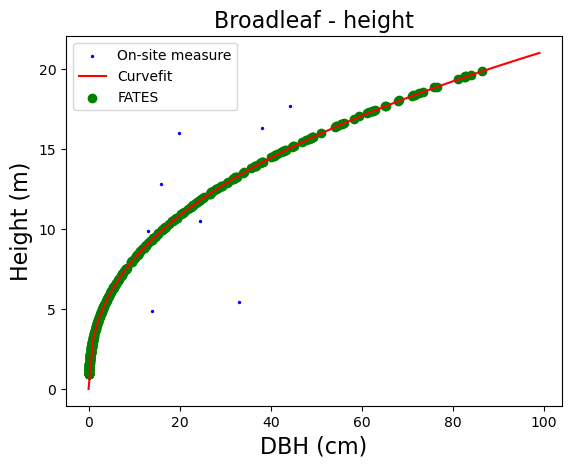

In [36]:
# ens_num: the picked ensemble member to show here
ens_num=40
time_slice=0

# Obtain allometric correlation from Tree measurements
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess_h = [58.0, 0.73, 21.8]

idx_good = bl_hi_obs>0
xdata_tmp = bl_dbh_obs[idx_good]
ydata_tmp = bl_hi_obs[idx_good]
# Exclude Nan
idx_nonan = ~np.isnan(xdata_tmp)

xdata = xdata_tmp[idx_nonan]
ydata = ydata_tmp[idx_nonan]

height_ps_evg_bl, height_cov_evg = curve_fit(f=d2hmc, xdata=xdata, ydata=ydata,
                                           p0=initial_guess_h)
dbh_evg_h = np.arange(0,100)
evg_curve_h = [d2hmc(d, height_ps_evg_bl[0], height_ps_evg_bl[1], height_ps_evg_bl[2])  for  d  in dbh_evg_h]

plt.scatter(xdata, ydata, c='blue', s=2)
plt.plot(dbh_evg_h, evg_curve_h, color='red')

tmp_fates_cdbh = arr_cdbh[ens_num,time_slice,:]
tmp_fates_cpft = arr_cpft[ens_num,time_slice,:]
tmp_fates_cheight = arr_cheight[ens_num,time_slice,:]
fates_cdh_bl = tmp_fates_cdbh[tmp_fates_cpft==1]
fates_cheight_bl = tmp_fates_cheight[tmp_fates_cpft==1]
plt.scatter(fates_cdh_bl, fates_cheight_bl, color='g')

plt.legend(['On-site measure', 'Curvefit', 'FATES'])
plt.title('Broadleaf - height', fontsize=16)
plt.ylabel('Height (m)', fontsize=16)
plt.xlabel('DBH (cm)', fontsize=16)

Text(0.5, 1.0, 'broadleaf')

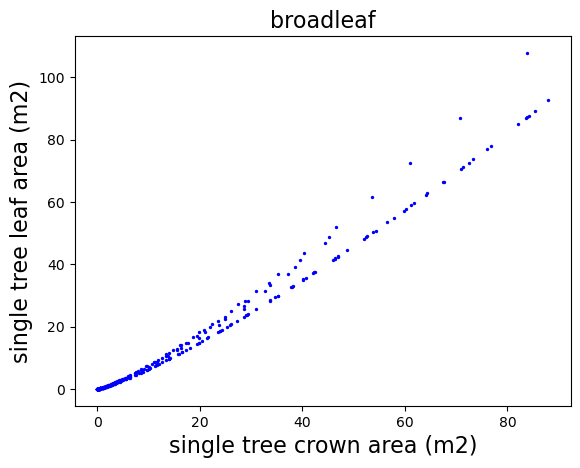

In [39]:
### Check fates leaf vs. crown area
# ens_num: the picked ensemble member to show here
ens_num=40
time_slice=0

# The first dimension is ensemble member #, can pick one from 0 to 253
tmp_fates_cdbh = arr_cdbh[ens_num,time_slice,:]
tmp_fates_cpft = arr_cpft[ens_num,time_slice,:]
tmp_fates_clai = arr_clai[ens_num,time_slice,:]
tmp_fates_ccarea = arr_ccarea[ens_num,time_slice,:]
tmp_fates_cnplant = arr_cnplant[ens_num,time_slice,:]
fates_cdh_nl = tmp_fates_cdbh[tmp_fates_cpft==2]
fates_clai_nl = tmp_fates_clai[tmp_fates_cpft==2]
fates_ccarea_nl = tmp_fates_ccarea[tmp_fates_cpft==2]
fates_cnplant_nl = tmp_fates_cnplant[tmp_fates_cpft==2]
fates_cdh_bl = tmp_fates_cdbh[tmp_fates_cpft==1]
fates_clai_bl = tmp_fates_clai[tmp_fates_cpft==1]
fates_ccarea_bl = tmp_fates_ccarea[tmp_fates_cpft==1]
fates_cnplant_bl = tmp_fates_cnplant[tmp_fates_cpft==1]

plt.scatter(fates_ccarea_bl/fates_cnplant_bl, fates_clai_bl*fates_ccarea_bl/fates_cnplant_bl, c='blue', s=2)
plt.ylabel('Single tree leaf area (m2)', fontsize=16)
plt.xlabel('Single tree crown area (m2)', fontsize=16)
plt.title('broadleaf', fontsize=16)

Text(0.5, 1.0, 'needleleaf')

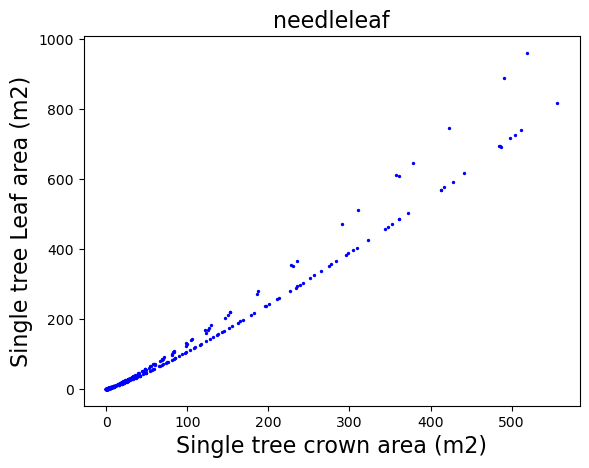

In [41]:
### Check fates leaf vs. crown area
plt.scatter(fates_ccarea_nl/fates_cnplant_nl, fates_clai_nl*fates_ccarea_nl/fates_cnplant_nl, c='blue', s=2)
plt.ylabel('Single tree Leaf area (m2)', fontsize=16)
plt.xlabel('Single tree crown area (m2)', fontsize=16)
# plt.xlim([-10, 200])
plt.title('needleleaf', fontsize=16)

Text(0.5, 1.0, 'needleleaf')

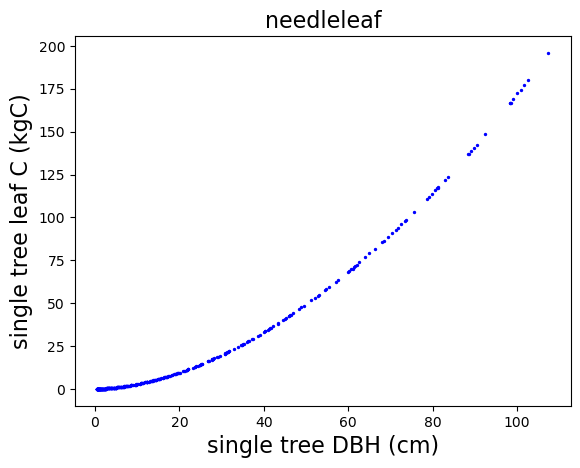

In [42]:
### Check fates leaf biomass vs. DBH
# ens_num: the picked ensemble member to show here
ens_num=40
time_slice=0

# The first dimension is ensemble member #, can pick one from 0 to 253
tmp_fates_cdbh = arr_cdbh[ens_num,time_slice,:]
tmp_fates_cpft = arr_cpft[ens_num,time_slice,:]
tmp_fates_cleafc = arr_cleafc[ens_num,time_slice,:]
tmp_fates_ccarea = arr_ccarea[ens_num,time_slice,:]
tmp_fates_cnplant = arr_cnplant[ens_num,time_slice,:]
fates_cdh_nl = tmp_fates_cdbh[tmp_fates_cpft==2]
fates_cleafc_nl = tmp_fates_cleafc[tmp_fates_cpft==2]
fates_ccarea_nl = tmp_fates_ccarea[tmp_fates_cpft==2]
fates_cnplant_nl = tmp_fates_cnplant[tmp_fates_cpft==2]
fates_cdh_bl = tmp_fates_cdbh[tmp_fates_cpft==1]
fates_cleafc_bl = tmp_fates_cleafc[tmp_fates_cpft==1]
fates_ccarea_bl = tmp_fates_ccarea[tmp_fates_cpft==1]
fates_cnplant_bl = tmp_fates_cnplant[tmp_fates_cpft==1]

plt.scatter(fates_cdh_nl, fates_cleafc_nl, c='blue', s=2)
plt.ylabel('single tree leaf C (kgC)', fontsize=16)
plt.xlabel('single tree DBH (cm)', fontsize=16)
plt.title('needleleaf', fontsize=16)

Text(0.5, 1.0, 'broadleaf')

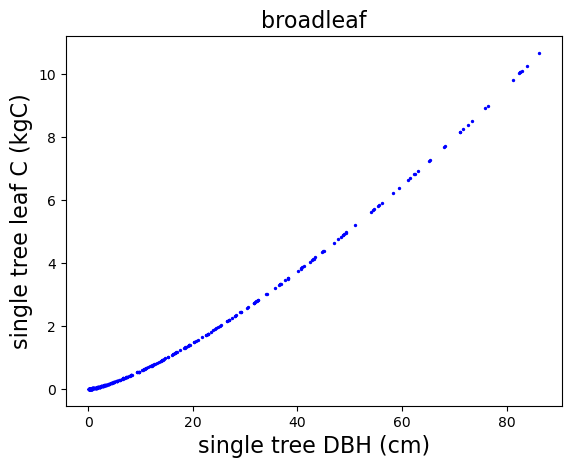

In [43]:
### Check fates leaf biomass vs. DBH
plt.scatter(fates_cdh_bl, fates_cleafc_bl, c='blue', s=2)
plt.ylabel('single tree leaf C (kgC)', fontsize=16)
plt.xlabel('single tree DBH (cm)', fontsize=16)
plt.title('broadleaf', fontsize=16)

In [44]:
# Crown area
def d2ca (d, p1, p2) :
    ca = p1 * d ** p2
    return ca

initial_guess_ca = [0.07, 1.3]

In [130]:
# Transfer RS measured height into DBH
# First we randomly pick 30% samples as oak and 70% as pine
idx_height = np.arange(0,len(height_rs))
idx_nl = np.random.choice(idx_height, size=[int(len(idx_height)*0.7)], replace=False)
idx_bl = np.intersect1d(np.setxor1d(idx_height, idx_nl), idx_height)

# Build 1 to 1 map (height -> dbh), broadleaf
dbh_map_table = np.arange(0,200,0.01)
map_table = [d2hmc(d, height_ps_evg_bl[0], height_ps_evg_bl[1], height_ps_evg_bl[2])  for  d  in dbh_map_table]
dbh_bl_rs = dbh_map_table[np.searchsorted(map_table,height_rs[idx_bl])-1]
crown_bl_rs = crown_rs[idx_bl]
crown_bl_rs[dbh_bl_rs>175] = np.nan
dbh_bl_rs[dbh_bl_rs>175] = np.nan

# Build 1 to 1 map (height -> dbh), needleleaf
dbh_map_table = np.arange(0,200,0.01)
map_table = [d2hmc(d, height_ps_evg_nl[0], height_ps_evg_nl[1], height_ps_evg_nl[2])  for  d  in dbh_map_table]
dbh_nl_rs = dbh_map_table[np.searchsorted(map_table,height_rs[idx_nl])-1]
crown_nl_rs = crown_rs[idx_nl]
crown_nl_rs[dbh_nl_rs>175] = np.nan
dbh_nl_rs[dbh_nl_rs>175] = np.nan


Text(0, 0.5, 'Crown area, $m^2$')

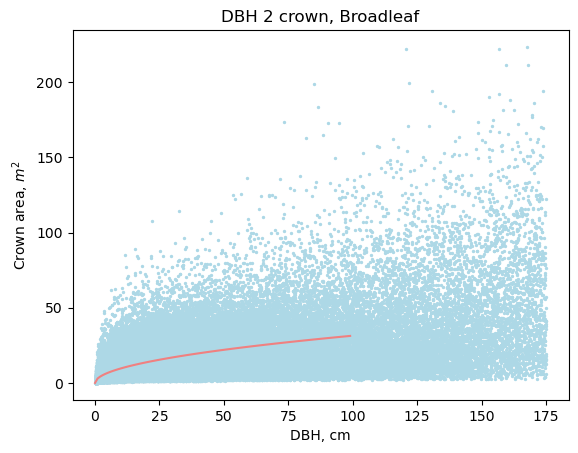

In [131]:
# Fit curve and get parameters for FATES allometric equations
dbh_bl_rs = dbh_bl_rs[~np.isnan(dbh_bl_rs)]
crown_bl_rs = crown_bl_rs[~np.isnan(crown_bl_rs)]

# Curvefit
ca_ps_evg_bl, ca_cov_evg = curve_fit(f=d2ca, xdata=dbh_bl_rs, ydata=crown_bl_rs,
                                           p0=initial_guess_ca)
dbh_evg_h = np.arange(0,100)
evg_curve_h = [d2ca(d, ca_ps_evg_bl[0], ca_ps_evg_bl[1])  for  d  in dbh_evg_h]

plt.scatter(dbh_bl_rs, crown_bl_rs, c='lightblue', s=2)
plt.plot(dbh_evg_h, evg_curve_h, color='lightcoral')
plt.title('DBH 2 crown, Broadleaf')
plt.xlabel('DBH, cm')
plt.ylabel('Crown area, $m^2$')

Text(0, 0.5, 'Crown area, $m^2$')

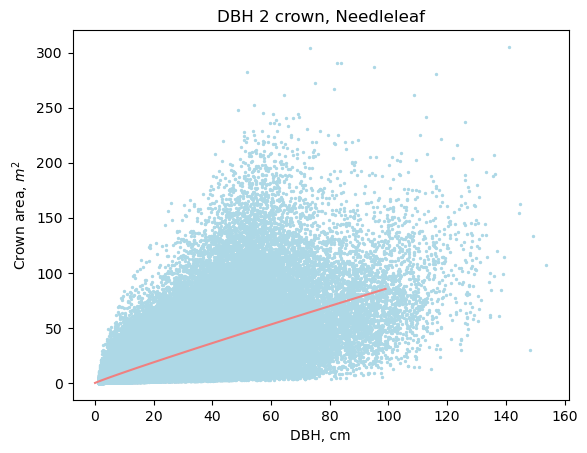

In [132]:
dbh_nl_rs = dbh_nl_rs[~np.isnan(dbh_nl_rs)]
crown_nl_rs = crown_nl_rs[~np.isnan(crown_nl_rs)]

# Curvefit
ca_ps_evg_nl, ca_cov_evg = curve_fit(f=d2ca, xdata=dbh_nl_rs, ydata=crown_nl_rs,
                                           p0=initial_guess_ca)
dbh_evg_h = np.arange(0,100)
evg_curve_h = [d2ca(d, ca_ps_evg_nl[0], ca_ps_evg_nl[1])  for  d  in dbh_evg_h]

plt.scatter(dbh_nl_rs, crown_nl_rs, c='lightblue', s=2)
plt.plot(dbh_evg_h, evg_curve_h, color='lightcoral')
plt.title('DBH 2 crown, Needleleaf')
plt.xlabel('DBH, cm')
plt.ylabel('Crown area, $m^2$')

In [80]:
# Get the population against binned height from FATES
# ens_num: the picked ensemble member to show here
time_slice=2

# Use to show all members
can_idx_all = np.arange(0,nens)

binned_n_fates = np.zeros((len(can_idx_all), len(height_bin)))
frac_binned_n_fates = np.zeros((len(can_idx_all), len(height_bin)))
bias = np.zeros((len(can_idx_all)))
for i in can_idx_all:
    for i_co in np.arange(0,len(arr_cheight[i,time_slice,:])):
        idx = int(arr_cheight[i,time_slice,i_co]/5) - 1
        if idx>=0:
            if(arr_can[i,time_slice,i_co] == 1):
                binned_n_fates[i, idx] = binned_n_fates[i, idx] + arr_cnplant[i,time_slice,i_co]
    # Obtain the relative fraction
    frac_binned_n_fates[i,:] = binned_n_fates[i,:]/np.sum(binned_n_fates[i,:])

# Perform comparison and pick the best
for i in can_idx_all:
    bias[i] = bias[i] + np.sum(np.abs(frac_binned_n_fates[i,0:9] - frac_n_rs[0:9]))

can = np.argmin(bias)


In [76]:
can

602

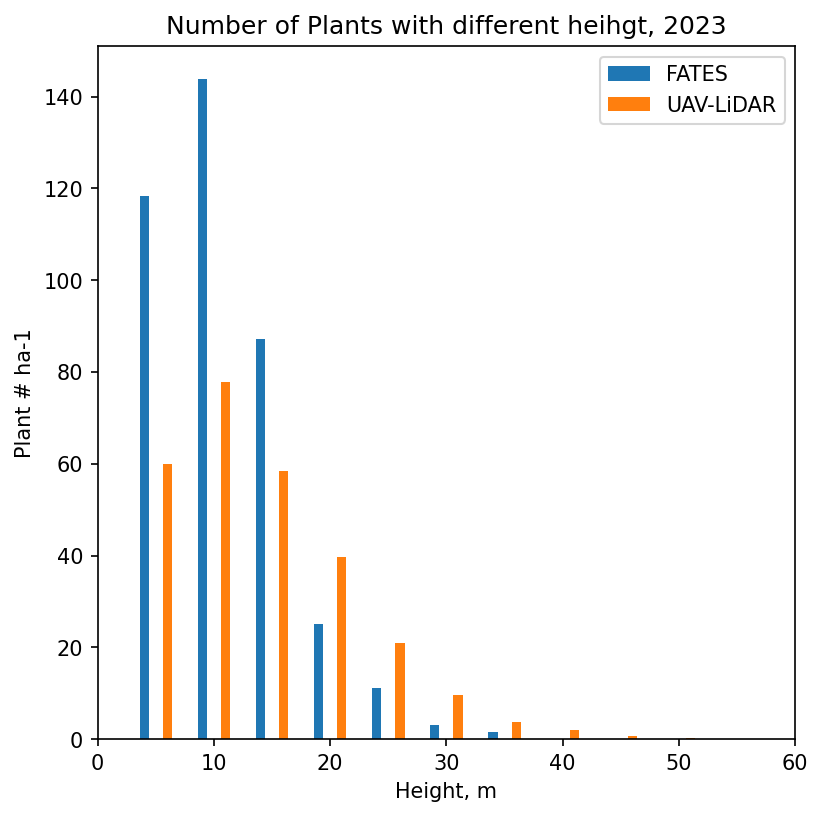

In [77]:
fig = plt.figure(figsize=(6,6), dpi=150)
# binned_n_fates_mean = np.nanmean(binned_n_fates[can_idx_all, :], axis=0)
# binned_n_fates_std = np.nanstd(binned_n_fates[can_idx_all, :], axis=0)
plt.bar(height_bin - 1, binned_n_fates[can,:])
plt.bar(height_bin + 1, 1e4*binned_n_rs/rs_area)
plt.xlabel('Height, m')
plt.ylabel('Plant # ha-1')
plt.xlim([0,60])
plt.legend(['FATES', 'UAV-LiDAR'])
plt.title('Number of Plants with different heihgt, 2023', fontsize=12)
plt.savefig('NPlant.png')

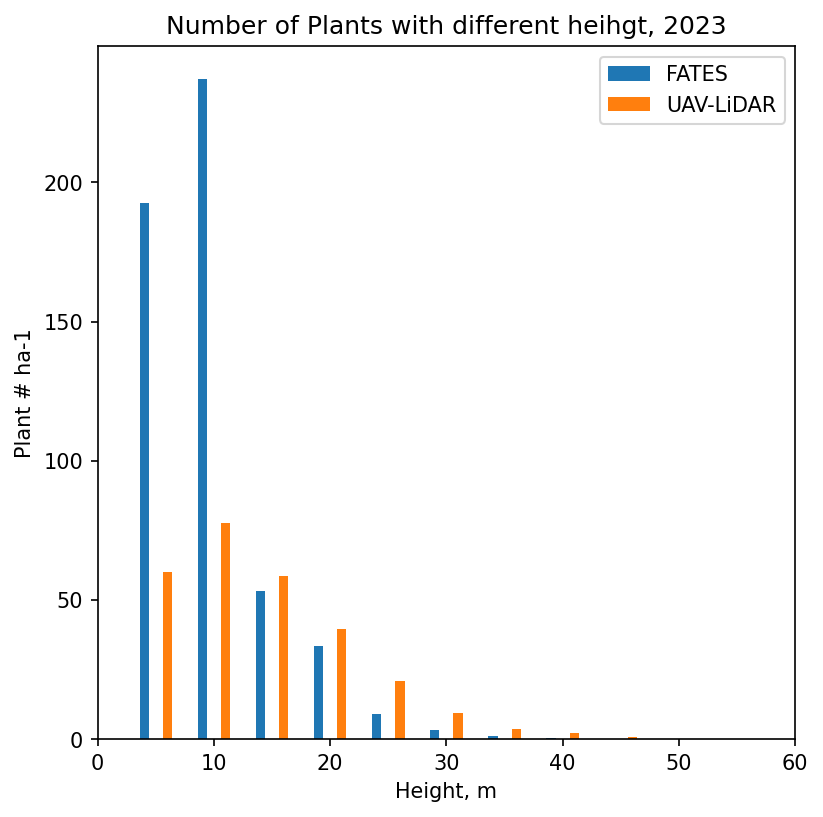

In [79]:
fig = plt.figure(figsize=(6,6), dpi=150)
# binned_n_fates_mean = np.nanmean(binned_n_fates[can_idx_all, :], axis=0)
# binned_n_fates_std = np.nanstd(binned_n_fates[can_idx_all, :], axis=0)
plt.bar(height_bin - 1, binned_n_fates[602,:])
plt.bar(height_bin + 1, 1e4*binned_n_rs/rs_area)
plt.xlabel('Height, m')
plt.ylabel('Plant # ha-1')
plt.xlim([0,60])
plt.legend(['FATES', 'UAV-LiDAR'])
plt.title('Number of Plants with different heihgt, 2023', fontsize=12)
plt.savefig('NPlant.png')

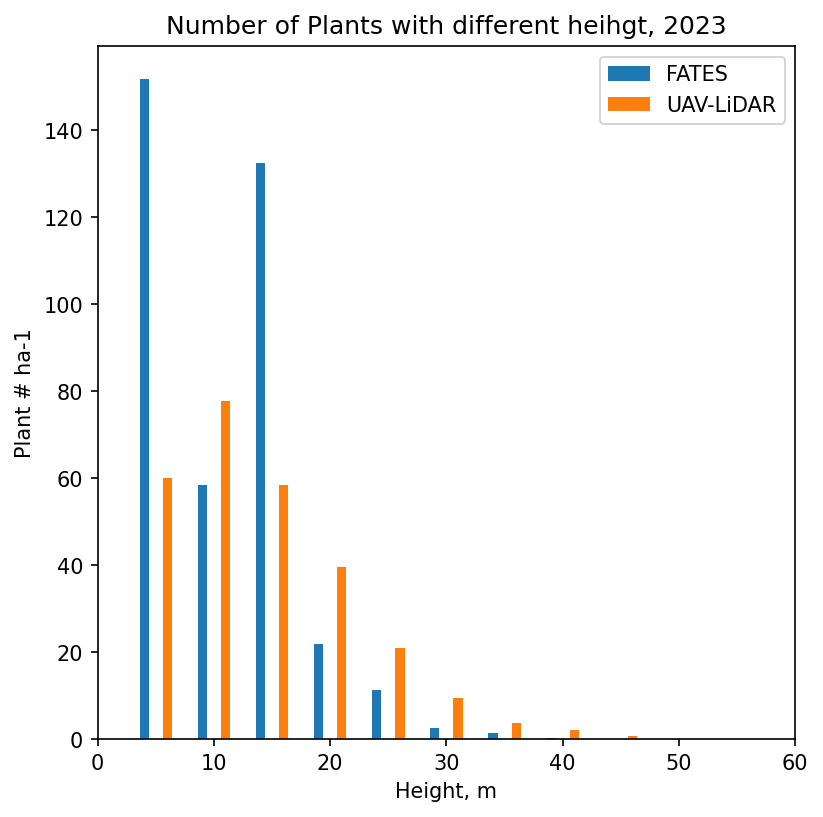

In [81]:
fig = plt.figure(figsize=(6,6), dpi=150)
# binned_n_fates_mean = np.nanmean(binned_n_fates[can_idx_all, :], axis=0)
# binned_n_fates_std = np.nanstd(binned_n_fates[can_idx_all, :], axis=0)
plt.bar(height_bin - 1, binned_n_fates[602,:])
plt.bar(height_bin + 1, 1e4*binned_n_rs/rs_area)
plt.xlabel('Height, m')
plt.ylabel('Plant # ha-1')
plt.xlim([0,60])
plt.legend(['FATES', 'UAV-LiDAR'])
plt.title('Number of Plants with different heihgt, 2023', fontsize=12)
plt.savefig('NPlant.png')

Text(0.5, 1.0, 'Spinup after 600 years')

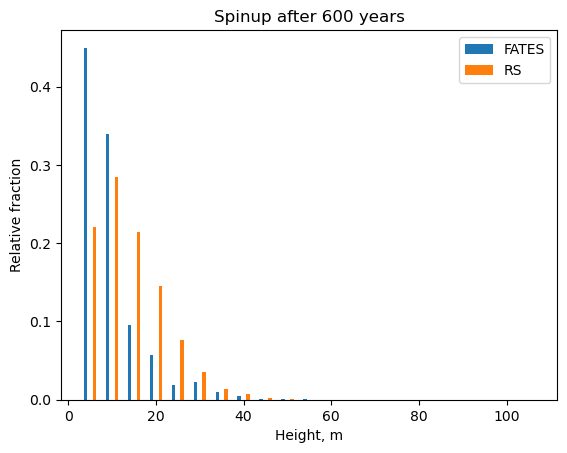

In [28]:
plt.bar(height_bin - 1, frac_binned_n_fates[can,:])
plt.bar(height_bin + 1, frac_n_rs)
plt.xlabel('Height, m')
plt.ylabel('Relative fraction')
plt.legend(['FATES', 'RS'])
plt.title('Spinup after 600 years')

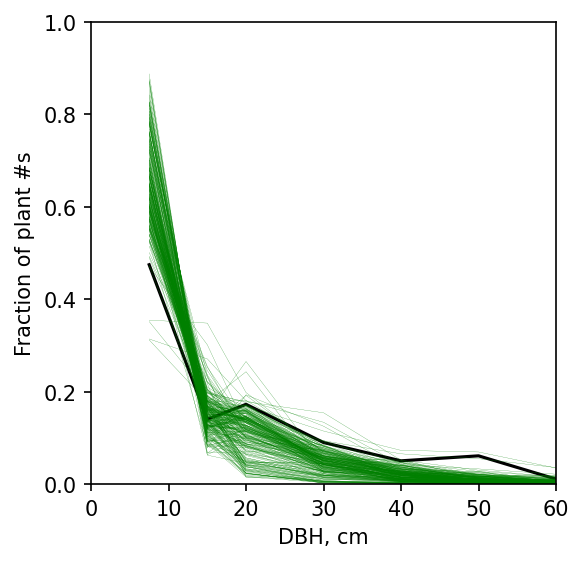

In [84]:
fig = plt.figure(figsize=(4,4), dpi=150)
lower_bin_edge_obs = np.array([7.5, 15, 20, 30, 40, 50, 60])
lower_bin_edge_ens = np.array([0, 7.5, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150])
plt.plot(lower_bin_edge_obs, obs_sz_frac, 'k-')
plt.xlim([0.0, 60.0])
plt.ylim([0.0, 1.0])
plt.xlabel('DBH, cm')
plt.ylabel('Fraction of plant #s')
offset_year = 10
# for i in np.arange(0,254):
for i in can_idx_all:
    ens_sz_frac = arr_num_sz_mean[i,np.shape(arr_num_sz_mean)[1]-offset_year,1:13]/np.sum(arr_num_sz_mean[i,np.shape(arr_num_sz_mean)[1]-offset_year,1:13])
    plt.plot(lower_bin_edge_ens[1:13], ens_sz_frac, 'g-', linewidth=0.1)

Text(0.5, 1.0, 'Spinup after 600 years')

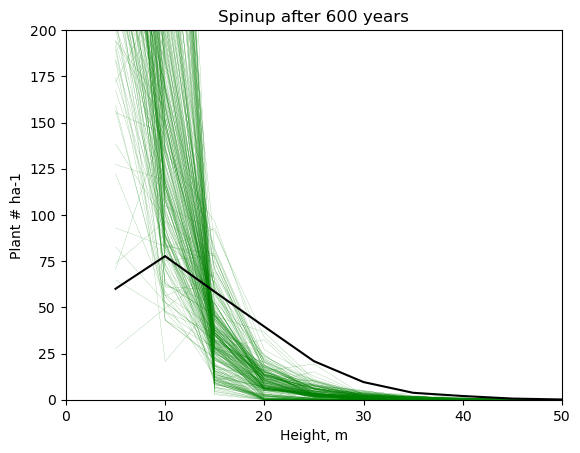

In [66]:
for iens in np.arange(0,254):
    plt.plot(height_bin, binned_n_fates[iens,:], 'g-', linewidth=0.1)
plt.plot(height_bin, 1e4*binned_n_rs/rs_area, 'k-')
plt.xlim([0,50])
plt.ylim([0,200])
plt.xlabel('Height, m')
plt.ylabel('Plant # ha-1')
# plt.legend(['FATES', 'RS'])
plt.title('Spinup after 600 years')

Text(0.5, 1.0, 'Spinup after 200 years')

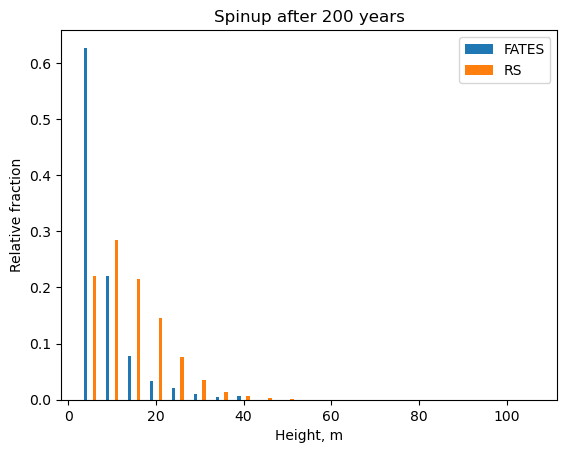

In [125]:
plt.bar(height_bin - 1, frac_binned_n_fates[can,:])
plt.bar(height_bin + 1, frac_n_rs)
plt.xlabel('Height, m')
plt.ylabel('Relative fraction')
plt.legend(['FATES', 'RS'])
plt.title('Spinup after 200 years')

Text(0.5, 1.0, 'Spinup after 400 years')

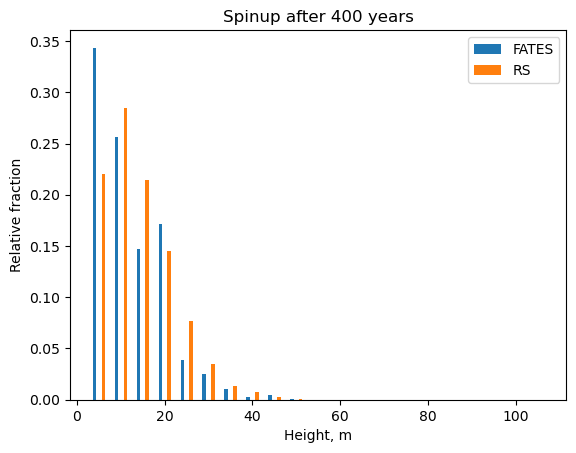

In [80]:
plt.bar(height_bin - 1, frac_binned_n_fates[can,:])
plt.bar(height_bin + 1, frac_n_rs)
plt.xlabel('Height, m')
plt.ylabel('Relative fraction')
plt.legend(['FATES', 'RS'])
plt.title('Spinup after 400 years')

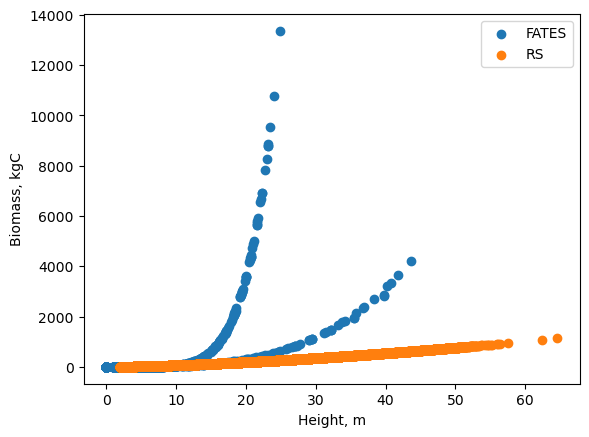

In [134]:
# Show the best matched candidate
plt.scatter(arr_cheight[can,0,:], arr_abg_c[can,0,:])

plt.scatter(height_rs, biomass_rs)
# plt.ylim([0,2000])
plt.xlabel('Height, m')
plt.ylabel('Biomass, kgC')
plt.legend(['FATES', 'RS'])

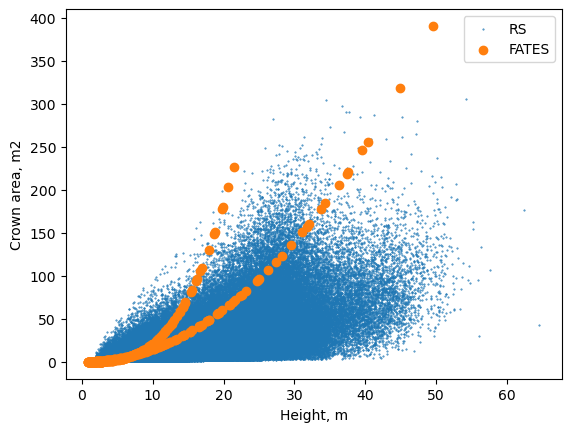

In [133]:
plt.scatter(height_rs, crown_rs, s=.2)
arr_cheight_plot = arr_cheight[can,1,:]
arr_ccarea_plot = arr_ccarea[can,1,:]
arr_cnplant_plot = arr_cnplant[can,1,:]
arr_cheight_plot[arr_cnplant_plot<1e-1] = np.nan
arr_ccarea_plot[arr_cnplant_plot<1e-1] = np.nan
arr_cnplant_plot[arr_cnplant_plot<1e-1] = np.nan
# plt.scatter(arr_cheight[can,1,:], arr_ccarea[can,1,:]/arr_cnplant[can,1,:])
plt.scatter(arr_cheight_plot, arr_ccarea_plot/arr_cnplant_plot)

# plt.ylim([0,2000])
plt.xlabel('Height, m')
plt.ylabel('Crown area, m2')
plt.legend(['RS', 'FATES'])

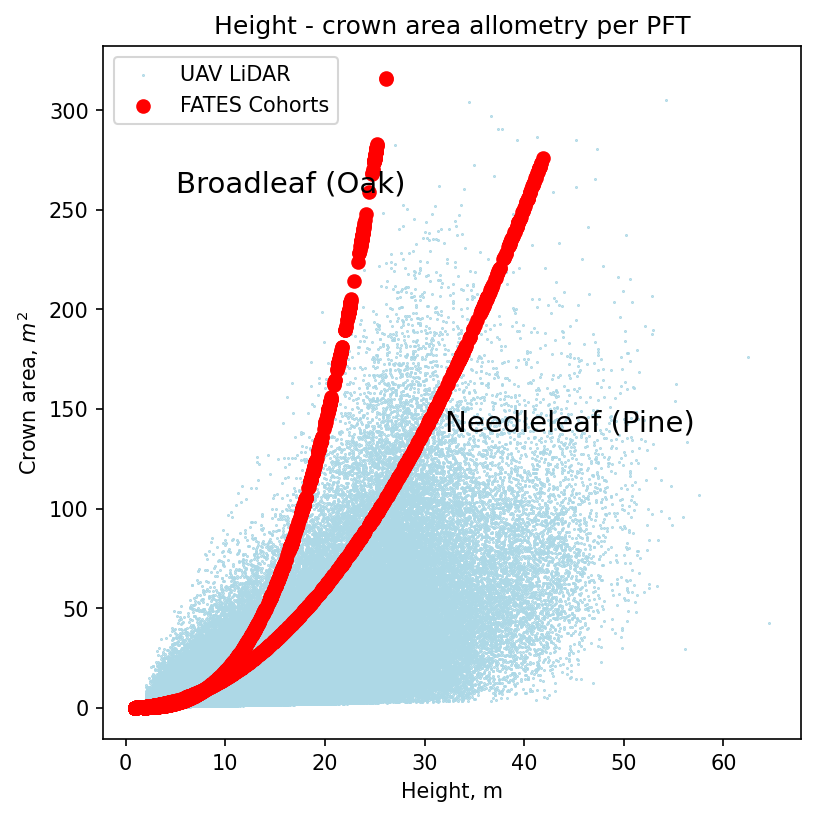

In [86]:
fig = plt.figure(figsize=(6,6), dpi=150)

# Get separted BL and NL
tmp_fates_cpft = arr_cpft[can,0,:]
tmp_fates_cheight = arr_cheight[can,0,:]
tmp_fates_ccarea = arr_ccarea[can,0,:]
tmp_fates_cnplant = arr_cnplant[can,0,:]
fates_cheight_nl = tmp_fates_cheight[tmp_fates_cpft==2]
fates_ccarea_nl = tmp_fates_ccarea[tmp_fates_cpft==2]
fates_cnplant_nl = tmp_fates_cnplant[tmp_fates_cpft==2]
fates_cheight_bl = tmp_fates_cheight[tmp_fates_cpft==1]
fates_ccarea_bl = tmp_fates_ccarea[tmp_fates_cpft==1]
fates_cnplant_bl = tmp_fates_cnplant[tmp_fates_cpft==1]

plt.scatter(height_rs, crown_rs, s=.2, color='lightblue')
plt.scatter(fates_cheight_bl, fates_ccarea_bl/fates_cnplant_bl, color='red')
plt.scatter(fates_cheight_nl[fates_cheight_nl<42], fates_ccarea_nl[fates_cheight_nl<42]/fates_cnplant_nl[fates_cheight_nl<42], color='red', label='_nolegend_')

plt.text(32.0, 150.0, 'Needleleaf (Pine)', fontsize=14, verticalalignment='top')
plt.text(5.0, 270.0, 'Broadleaf (Oak)', fontsize=14, verticalalignment='top')

# plt.ylim([0,2000])
plt.xlabel('Height, m')
plt.ylabel('Crown area, $m^{2}$')
plt.title('Height - crown area allometry per PFT')
plt.legend(['UAV LiDAR', 'FATES Cohorts'])
plt.savefig('H_canopy_allo.png')

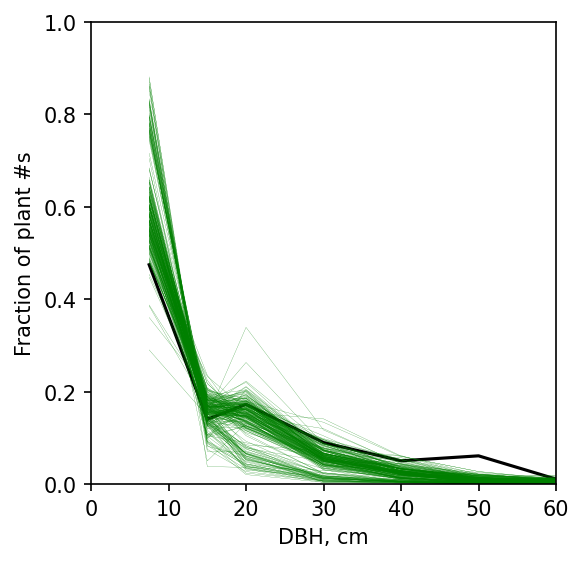

In [61]:
fig = plt.figure(figsize=(4,4), dpi=150)
lower_bin_edge_obs = np.array([7.5, 15, 20, 30, 40, 50, 60])
lower_bin_edge_ens = np.array([0, 7.5, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150])
plt.plot(lower_bin_edge_obs, obs_sz_frac, 'k-')
plt.xlim([0.0, 60.0])
plt.ylim([0.0, 1.0])
plt.xlabel('DBH, cm')
plt.ylabel('Fraction of plant #s')
offset_year = 10
# for i in np.arange(0,254):
for i in can_idx_all:
    ens_sz_frac = arr_num_sz_mean[i,np.shape(arr_num_sz_mean)[1]-offset_year,1:13]/np.sum(arr_num_sz_mean[i,np.shape(arr_num_sz_mean)[1]-offset_year,1:13])
    plt.plot(lower_bin_edge_ens[1:13], ens_sz_frac, 'g-', linewidth=0.1)

(0.0, 3000.0)

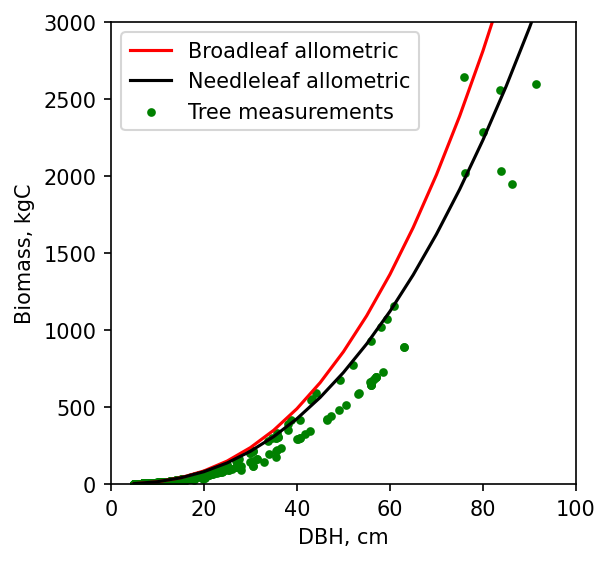

In [65]:
# line plot to compare with the biomass against size through allometric equations
fig = plt.figure(figsize=(4,4), dpi=150)
d = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
p1 = [0.089, 0.1229]
p2 = [2.5226, 2.3964]
abg_bl = []
abg_nl = []
for i in d:
    abg_bl.append((p1[0] * i**p2[0])/2)
    abg_nl.append((p1[1] * i**p2[1])/2)
plt.plot(d, abg_bl, 'r-')
plt.plot(d, abg_nl, 'k-')
plt.scatter(dbh_obs, vegc_obs,  c='green', s=10)
# for i in np.arange(0,nens):
#     plt.scatter(arr_cdbh[i,9,:], arr_abg_c[i,9,:], s=2)
    
plt.xlabel('DBH, cm')
plt.ylabel('Biomass, kgC')
plt.legend(['Broadleaf allometric', 'Needleleaf allometric', 'Tree measurements'])
plt.xlim([0,100])
plt.ylim([0,3000])

### Check growth rate

In [ ]:
### 

### Check the results from size-dependet harvesting experiments

In [115]:
dbh = np.arange(0,60)
logging_dbhmin = 15
logging_dbhmax = 45
sigma = 5
# Logistic curve
hrv_rate = 1.33/(1.0 + np.exp(-0.1*(dbh-(logging_dbhmin+logging_dbhmax)/2.0)))
# Inverse logistic curve
hrv_rate2 = 1.33/(1.0 + np.exp(0.1*(dbh-(logging_dbhmin+logging_dbhmax)/2.0)))
# Gaussian curve
hrv_rate3 = 3.0* np.exp(-(dbh - (logging_dbhmin+logging_dbhmax)/2.0) ** 2 / (2 * sigma ** 2))

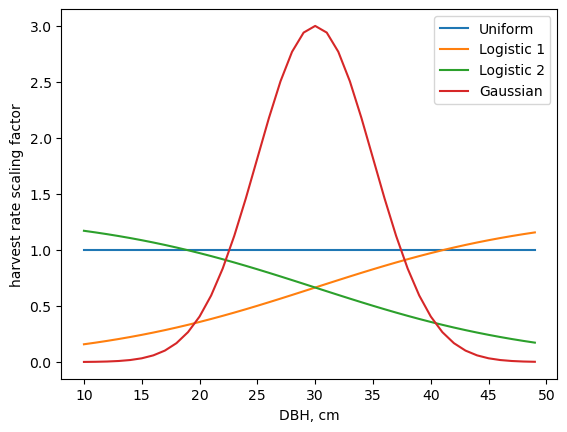

In [118]:
plt.plot(np.arange(10,50), 1.0*np.ones((np.shape(np.arange(10,50)))))
plt.plot(np.arange(10,50), hrv_rate[10:50])
plt.plot(np.arange(10,50), hrv_rate2[10:50])
plt.plot(np.arange(10,50), hrv_rate3[10:50])
plt.ylabel('harvest rate scaling factor')
plt.xlabel('DBH, cm')
plt.legend(['Uniform', 'Logistic 1', 'Logistic 2', 'Gaussian'])

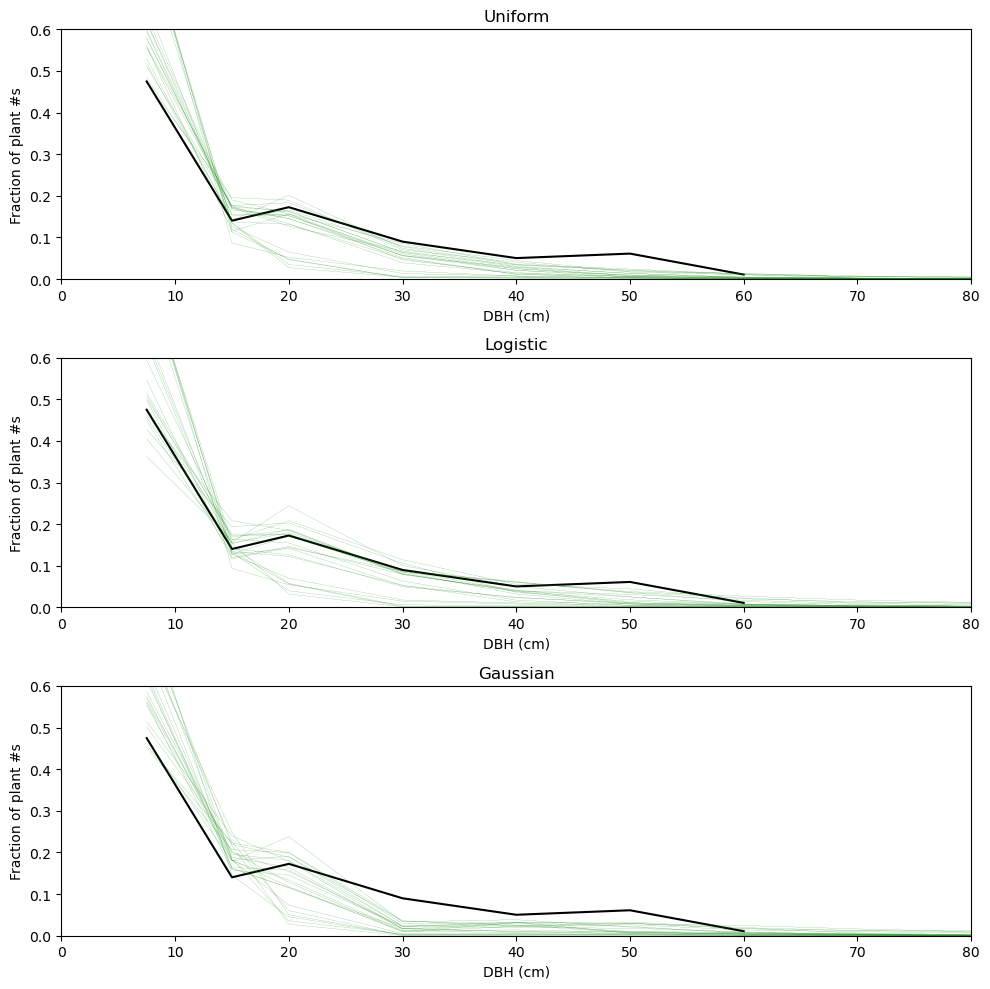

In [62]:
# set up the page
fig1, (f1ax0, f1ax1, f1ax2) = plt.subplots(nrows=3, figsize=(10, 10))

offset_year = 10
# for i in np.arange(0,254):
if 'can_idx_all' not in globals():
    can_idx_all = np.arange(0,254)

## set up the first plot: the fractional area of patches of a given age range
lower_bin_edge_obs = np.array([7.5, 15, 20, 30, 40, 50, 60])
lower_bin_edge_ens = np.array([0, 7.5, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150])
# Uniform
f1ax0.plot(lower_bin_edge_obs, obs_sz_frac, 'k-')
for i in can_idx_all:
    ens_sz_frac = arr_num_sz_allexp_mean[0,i,np.shape(arr_num_sz_allexp_mean)[2]-offset_year,1:13]/np.sum(arr_num_sz_allexp_mean[0,i,np.shape(arr_num_sz_allexp_mean)[2]-offset_year,1:13])
    f1ax0.plot(lower_bin_edge_ens[1:13], ens_sz_frac, 'g-', linewidth=0.1)
f1ax0.set_title(r'Uniform')
f1ax0.set_ylabel('Fraction of plant #s')
f1ax0.set_xlabel('DBH (cm)')
f1ax0.set_xlim([0.0, 80.0])
f1ax0.set_ylim([0.0, 0.6])

# Logistic
f1ax1.plot(lower_bin_edge_obs, obs_sz_frac, 'k-')
for i in can_idx_all:
    ens_sz_frac = arr_num_sz_allexp_mean[1,i,np.shape(arr_num_sz_allexp_mean)[2]-offset_year,1:13]/np.sum(arr_num_sz_allexp_mean[1,i,np.shape(arr_num_sz_allexp_mean)[2]-offset_year,1:13])
    f1ax1.plot(lower_bin_edge_ens[1:13], ens_sz_frac, 'g-', linewidth=0.1)
f1ax1.set_title(r'Logistic')
f1ax1.set_ylabel('Fraction of plant #s')
f1ax1.set_xlabel('DBH (cm)')
f1ax1.set_xlim([0.0, 80.0])
f1ax1.set_ylim([0.0, 0.6])

f1ax2.plot(lower_bin_edge_obs, obs_sz_frac, 'k-')
for i in can_idx_all:
    ens_sz_frac = arr_num_sz_allexp_mean[2, i,np.shape(arr_num_sz_allexp_mean)[2]-offset_year,1:13]/np.sum(arr_num_sz_allexp_mean[2,i,np.shape(arr_num_sz_allexp_mean)[2]-offset_year,1:13])
    f1ax2.plot(lower_bin_edge_ens[1:13], ens_sz_frac, 'g-', linewidth=0.1)
f1ax2.set_title(r'Gaussian')
f1ax2.set_ylabel('Fraction of plant #s')
f1ax2.set_xlabel('DBH (cm)')
f1ax2.set_xlim([0.0, 80.0])
f1ax2.set_ylim([0.0, 0.6])

## set up the third plot: the GPP, conditional on patch age

# show the plot
fig1.tight_layout()
plt.show()

Text(0, 0.5, 'ABG Veg C in kgC m-2')

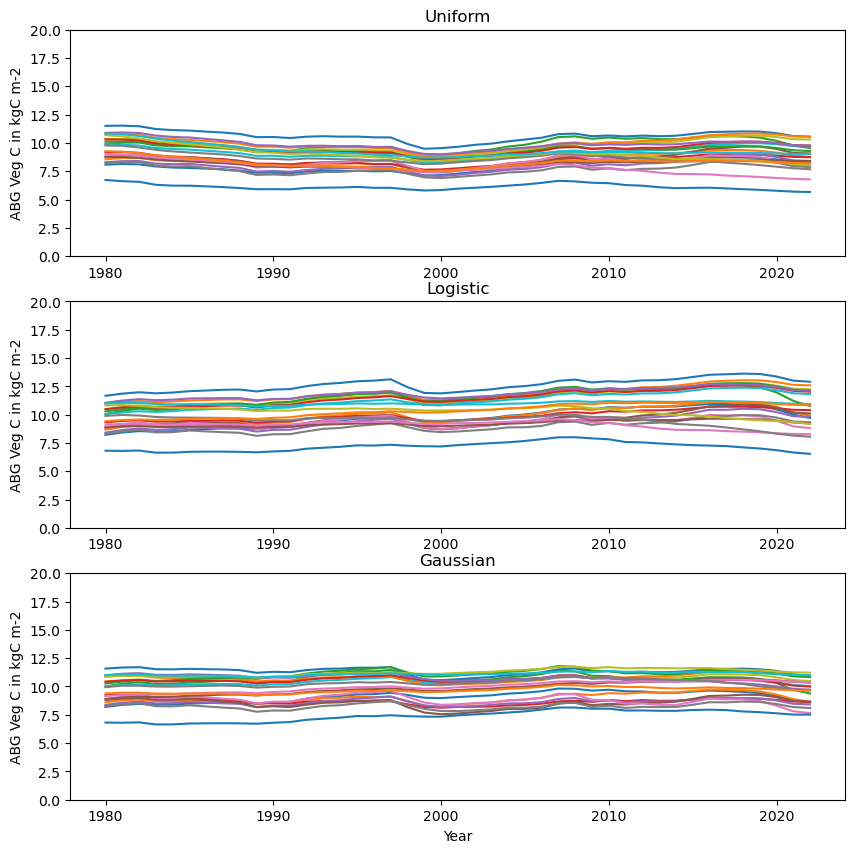

In [63]:
# Examine the vegetation carbon from different experiments
# Plot vegc time series from new candidates
fig1, (f1ax0, f1ax1, f1ax2) = plt.subplots(nrows=3, figsize=(10, 10))
for i in can_idx_all:
    f1ax0.plot(np.arange(1980, 2023), 0.6*(arr_vegc_nl_allexp_mean[0,i,0:nyr]+arr_vegc_bl_allexp_mean[0,i,0:nyr]))
f1ax0.set_ylim([0, 20])
f1ax0.set_title(r'Uniform')
#f1ax0.set_xlabel('Year')
f1ax0.set_ylabel('ABG Veg C in kgC m-2')

for i in can_idx_all:
    f1ax1.plot(np.arange(1980, 2023), 0.6*(arr_vegc_nl_allexp_mean[1,i,0:nyr]+arr_vegc_bl_allexp_mean[1,i,0:nyr]))
f1ax1.set_title(r'Logistic')
f1ax1.set_ylim([0, 20])
#f1ax1.set_xlabel('Year')
f1ax1.set_ylabel('ABG Veg C in kgC m-2')

for i in can_idx_all:
    f1ax2.plot(np.arange(1980, 2023), 0.6*(arr_vegc_nl_allexp_mean[2,i,0:nyr]+arr_vegc_bl_allexp_mean[2,i,0:nyr]))
f1ax2.set_title(r'Gaussian')
f1ax2.set_ylim([0, 20])
f1ax2.set_xlabel('Year')
f1ax2.set_ylabel('ABG Veg C in kgC m-2')


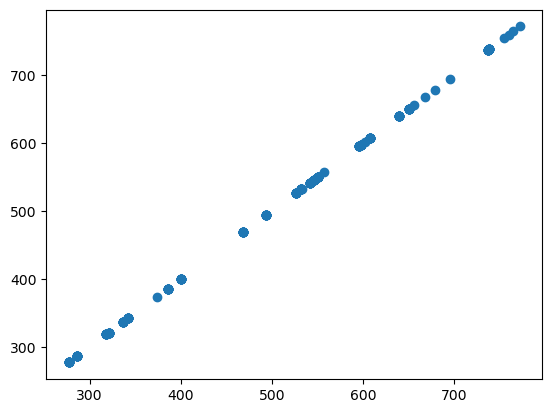

In [111]:
plt.scatter(arr_wd, arr_wd)

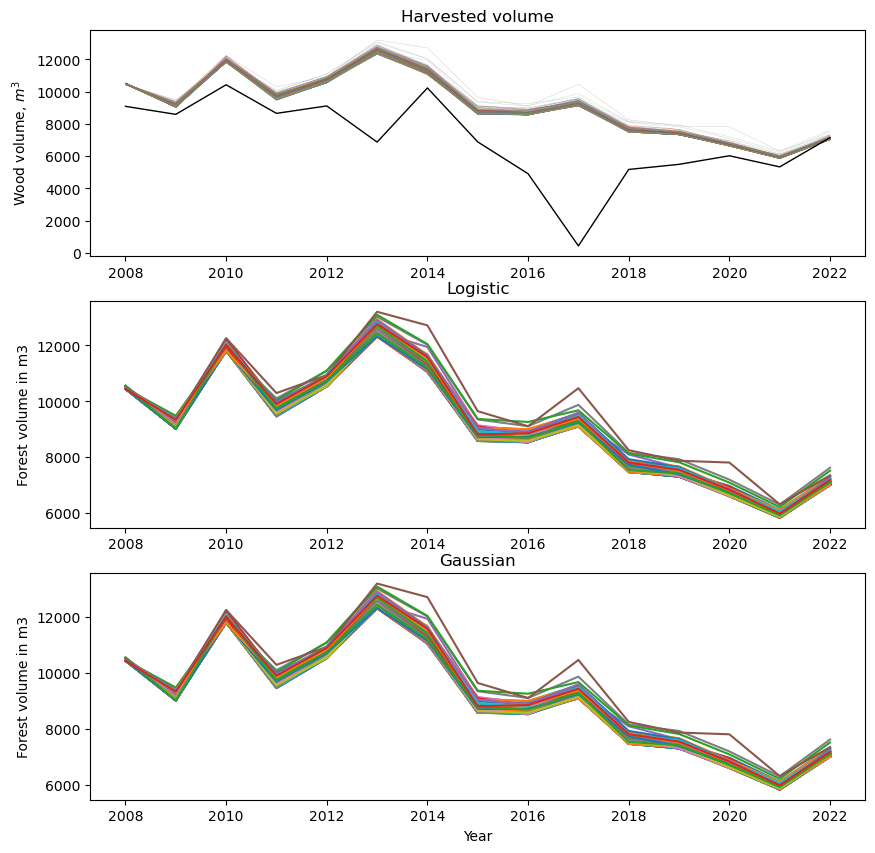

In [64]:
# Comparison of harvested forest volume against obs
can_idx_all = np.arange(0,254)
fig1, (f1ax0, f1ax1, f1ax2) = plt.subplots(nrows=3, figsize=(10, 10))
sh1_v = forest_area_ha * sh1_ts[210,159:174] / (arr_wd[210]*0.5)
for i in can_idx_all:
    f1ax0.plot(np.arange(2008, 2023), forest_area_ha*m2_to_ha*c_to_biomass*arr_wood_product_allexp_mean[0,i,28:nyr]/arr_wd[i], linewidth=0.1)
f1ax0.plot(np.arange(2008,2023),sh1_v, 'k-', linewidth=1.0)
# f1ax0.set_ylim([0, 20])
f1ax0.set_title(r'Harvested volume')
#f1ax0.set_xlabel('Year')
f1ax0.set_ylabel('Wood volume, $m^3$')

for i in can_idx_all:
    f1ax1.plot(np.arange(2008, 2023), forest_area_ha*m2_to_ha*c_to_biomass*arr_wood_product_allexp_mean[0,i,28:nyr]/arr_wd[i])
f1ax1.set_title(r'Logistic')
# f1ax1.set_ylim([0, 20])
#f1ax1.set_xlabel('Year')
f1ax1.set_ylabel('Forest volume in m3')

for i in can_idx_all:
    f1ax2.plot(np.arange(2008, 2023), forest_area_ha*m2_to_ha*c_to_biomass*arr_wood_product_allexp_mean[0,i,28:nyr]/arr_wd[i])
f1ax2.set_title(r'Gaussian')
# f1ax2.set_ylim([0, 20])
f1ax2.set_xlabel('Year')
f1ax2.set_ylabel('Forest volume in m3')

plt.savefig('harv_c.png')

### Plot C storage from selected candidates 

In [14]:
# Plot vegc time series from selected candidates
fig = plt.figure(figsize=(8,8), dpi=150)
nyr=20
# can_idx_all=np.arange(0,254)
# for i in can_idx_both:
    # plt.plot(np.arange(2000,2025), 0.6*(arr_vegc_nl_mean[i,0:nyr]+arr_vegc_bl_mean[i,0:nyr]))
can_std = np.nanstd(0.6*(arr_vegc_nl_mean[can_idx_refined,0:nyr]+arr_vegc_bl_mean[can_idx_refined,0:nyr]), axis=0)
soil_mean = np.nanmean((arr_soilc_mean[can_idx_refined,0:nyr]), axis=0)
can_mean = np.nanmean(0.6*(arr_vegc_nl_mean[can_idx_refined,0:nyr]+arr_vegc_bl_mean[can_idx_refined,0:nyr]), axis=0)
# for i in np.arange(0,254):
    # plt.plot(np.arange(2000,2015), 0.6*(arr_vegc_nl_mean[i,0:nyr]+arr_vegc_bl_mean[i,0:nyr]), 'b-', linewidth = 0.1)
# dcan_mean = can_mean[1:20] - can_mean[0:19]
can_mean_baseline = can_mean
can_std_baseline = can_std
can_std_exp = np.zeros((ncase, 5))
can_mean_exp = np.zeros((ncase, 5))
soil_mean_exp = np.zeros((ncase, 5))
for c in np.arange(0, ncase):
    can_std_exp[c,:] = np.nanstd(0.6*(arr_vegc_nl_allexp_mean[c,can_idx_refined,0:nyr]+arr_vegc_bl_allexp_mean[c,can_idx_refined,0:nyr]), axis=0)
    soil_mean_exp[c,:] = np.nanmean((arr_soilc_allexp_mean[c,can_idx_refined,0:nyr]), axis=0)
    can_mean_exp[c,:] = np.nanmean(0.6*(arr_vegc_nl_allexp_mean[c,can_idx_refined,0:nyr]+arr_vegc_bl_allexp_mean[c,can_idx_refined,0:nyr]), axis=0)
    
plt.plot(np.arange(2000,2020), can_mean_baseline[0:20], 'b-')
plt.plot(np.arange(2017,2023), np.concatenate([can_mean_baseline[17:18], can_mean_exp[0,:]]), 'g-')
plt.plot(np.arange(2017,2023), np.concatenate([can_mean_baseline[17:18], can_mean_exp[1,:]]), 'r-')
plt.plot(np.arange(2017,2023), np.concatenate([can_mean_baseline[17:18], can_mean_exp[2,:]]), 'y-')
plt.plot(np.arange(2017,2023), np.concatenate([can_mean_baseline[17:18], can_mean_exp[3,:]]), 'c-')
# plt.plot(np.arange(2000,2018), can_mean_baseline[0:18]+can_std_baseline[0:18], 'b-.', alpha=.3)
# plt.plot(np.arange(2000,2018), can_mean_baseline[0:18]-can_std_baseline[0:18], 'b-.', alpha=.3, label='_nolegend_')
car_vegc = np.array([94.06, 95.03, 98.05, 101.17, 105.23, 107.51]) * 0.1
caltivo = np.array([59.40,58.92,58.25,59.58,59.67,57.44,60.14]) * 0.1
planet = np.array([93.14,92.95,103.46,100.74,110.51,106.25,94.51,91.76,93.44,95.38]) * 0.1
planet_lower = np.array([19.42,19.46,23.17,22.18,26.06,24.76,20.08,19.94,19.19,20.99]) * 0.1
planet_upper = np.array([212.51,210.80,227.89,225.05,238.68,229.72,212.01,211.39,212.28,209.99]) * 0.1
chloris = np.array([89.837, 90.806, 91.691, 92.591, 93.425, 94.258, 95.100, 95.960, 96.789, 97.639, 98.521, 99.382, 100.233, 101.065, 101.846, 102.643, 103.701, 104.682, 105.615, 106.873, 108.144, 109.286, 110.517]) * 0.1
chloris_lower = np.array([85.293, 86.921, 88.267, 89.486, 90.545, 91.531, 92.483, 93.410, 94.286, 95.161, 96.036, 96.866, 97.663, 98.417, 99.101, 99.774, 100.750, 101.629, 102.486, 103.600, 104.714, 105.540, 106.151]) * 0.1
chloris_upper = np.array([94.382, 94.690, 95.116, 95.697, 96.306, 96.986, 97.718, 98.509, 99.291, 100.117, 101.006, 101.898, 102.804, 103.713, 104.592, 105.513, 106.653, 107.735, 108.744, 110.147, 111.574, 113.032, 114.882]) * 0.1
# old_fates = np.array([84.9460905, 85.7114415, 86.4723641, 87.0751345, 88.3214165, 88.9915389, 90.1441479, 92.2130828, 92.1105052, 90.3015856, 90.8078732, 89.7163095, 89.9900245, 89.4997104, 89.5353109, 90.5405453, 91.6057318, 91.4929283, 91.3120642, 90.6988281, 89.2260922, 87.3271728, 86.4931386])*0.1

# plt.plot(np.arange(2000,2023), 9.4*np.ones((23)), 'k-')
plt.plot(np.arange(2017,2023), car_vegc, 'k-')
# plt.plot(np.arange(2016,2023), caltivo, 'r-')
plt.plot(np.arange(2000,2023), chloris, 'g-')
# plt.plot(np.arange(2000,2023), chloris_lower, 'g--')
# plt.plot(np.arange(2000,2023), chloris_upper, 'g--', label='_nolegend_')
# plt.plot(np.arange(2000,2023), old_fates, 'y-')
plt.plot([2022], [11.924], 'o', color='gold')

plt.legend(['baseline', 'Double rotation length' , 'Harvest large tree (50cm) first', 'Harvest medium tree (40cm) first', 'Harvest small tree (30cm) first', 'CAR report', 'Chloris', 'UAV LiDAR'], fontsize=12)
plt.xlim([1999, 2023])
# plt.xlim([2018, 2023])
plt.ylim([5.5, 14.5])
plt.xlabel('Year', fontsize=18)
plt.ylabel('Aboveground Vegetation C, kgC $m^{-2}$', fontsize=18)
plt.savefig('ifm_example.png')

NameError: name 'can_idx_refined' is not defined

<Figure size 1200x1200 with 0 Axes>

In [37]:
# Plot vegc time series from new candidates
# for i in np.arange(0,254):
fig = plt.figure(figsize=(6,6), dpi=150)
for i in can_idx_all:
    plt.plot(ax_yr[1:nyr], arr_soilc_mean[i,1:nyr]-4, label='_nolegend_')
plt.ylim([15, 28])
plt.xlabel('Year')
plt.ylabel('Soil carbon in kgC $m^{-2}$')
plt.scatter(([2019]), ([22.4]), color='k', marker='*')
plt.legend(['2019 Soil C from SoilGrid = 22.4 kgC $m^{-2}$'])
plt.title('Soil carbon from all candidates')
plt.savefig('soilc.png')

(20,)

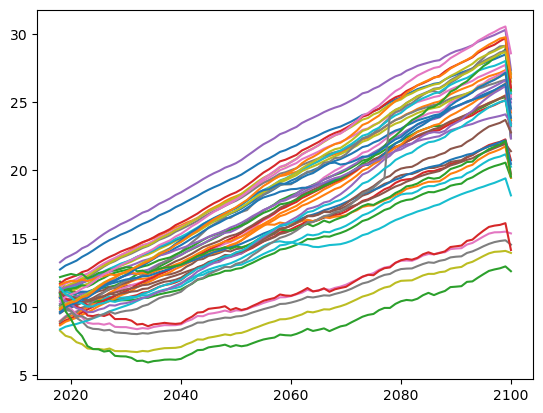

In [18]:
# Make plot for future
for iens in can_idx_all:
    plt.plot(np.arange(2018,2101), 0.6*(arr_vegc_nl_mean[iens,:]+arr_vegc_bl_mean[iens,:]))

In [16]:
can_idx_all

array([  3,   5,   9,  12,  15,  66,  75,  79, 161, 162, 163, 165, 166,
       168, 171, 173, 175, 255, 273, 275, 277, 280, 283, 287, 288, 289,
       290, 294, 300, 301, 303, 325, 331, 332, 470, 514, 545, 546, 547,
       550, 557, 559, 636])

In [233]:
can_mean_baseline=copy.deepcopy(can_mean)
can_std_baseline=copy.deepcopy(can_std)

In [262]:
backup = copy.deepcopy(can_mean_baseline)

In [271]:
can_mean_baseline[0:18] = can_mean[0:18] 
can_std_baseline[0:18] = can_std[0:18]
can_mean_baseline[0:18] = can_mean[0:18]
can_mean_baseline[18:25] = backup[18:25]
can_mean_baseline[18:25] = can_mean_baseline[18:25]*0.93
# can_mean_baseline[22:25] = can_mean_baseline[22:25]*0.98

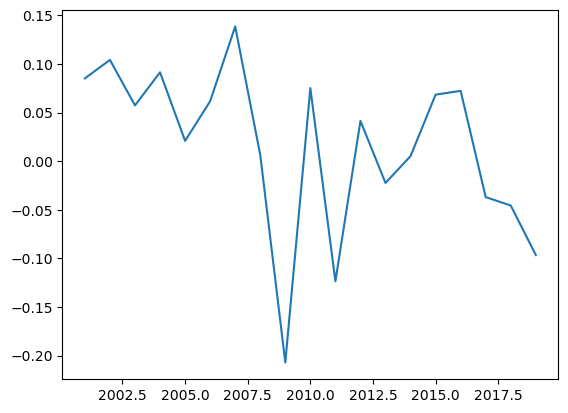

In [37]:
plt.plot(np.arange(2001, 2020), dcan_mean)

In [49]:
# Plot each ensemble member separately
# Plot vegc time series from selected candidates
# for i in can_idx_both:
    # plt.plot(np.arange(1850,2020), 0.6*(arr_vegc_nl_mean[i,0:nyr]+arr_vegc_bl_mean[i,0:nyr]))
can_std = np.nanstd(0.6*(arr_vegc_nl_mean[can_idx_all,0:nyr]+arr_vegc_bl_mean[can_idx_all,0:nyr]), axis=0)
can_mean = np.nanmean(0.6*(arr_vegc_nl_mean[can_idx_all,0:nyr]+arr_vegc_bl_mean[can_idx_all,0:nyr]), axis=0)
# for i in can_idx_all:
    # plt.plot(np.arange(2000,2023), 0.6*(arr_vegc_nl_mean[i,20:nyr]+arr_vegc_bl_mean[i,20:nyr]), 'b-', linewidth = 0.1)
plt.plot(np.arange(2000,2023), can_mean[20:43], 'b-')
plt.plot(np.arange(2000,2023), can_mean[20:43]+can_std[20:43], 'b-.')
plt.plot(np.arange(2000,2023), can_mean[20:43]-can_std[20:43], 'b-.')
car_vegc = np.array([94.06, 95.03, 98.05, 101.17, 105.23, 107.51]) * 0.1
caltivo = np.array([59.40,58.92,58.25,59.58,59.67,57.44,60.14]) * 0.1
planet = np.array([93.14,92.95,103.46,100.74,110.51,106.25,94.51,91.76,93.44,95.38]) * 0.1
planet_lower = np.array([19.42,19.46,23.17,22.18,26.06,24.76,20.08,19.94,19.19,20.99]) * 0.1
planet_upper = np.array([212.51,210.80,227.89,225.05,238.68,229.72,212.01,211.39,212.28,209.99]) * 0.1
chloris = np.array([89.837, 90.806, 91.691, 92.591, 93.425, 94.258, 95.100, 95.960, 96.789, 97.639, 98.521, 99.382, 100.233, 101.065, 101.846, 102.643, 103.701, 104.682, 105.615, 106.873, 108.144, 109.286, 110.517]) * 0.1
chloris_lower = np.array([85.293, 86.921, 88.267, 89.486, 90.545, 91.531, 92.483, 93.410, 94.286, 95.161, 96.036, 96.866, 97.663, 98.417, 99.101, 99.774, 100.750, 101.629, 102.486, 103.600, 104.714, 105.540, 106.151]) * 0.1
chloris_upper = np.array([94.382, 94.690, 95.116, 95.697, 96.306, 96.986, 97.718, 98.509, 99.291, 100.117, 101.006, 101.898, 102.804, 103.713, 104.592, 105.513, 106.653, 107.735, 108.744, 110.147, 111.574, 113.032, 114.882]) * 0.1
# old_fates = np.array([84.9460905, 85.7114415, 86.4723641, 87.0751345, 88.3214165, 88.9915389, 90.1441479, 92.2130828, 92.1105052, 90.3015856, 90.8078732, 89.7163095, 89.9900245, 89.4997104, 89.5353109, 90.5405453, 91.6057318, 91.4929283, 91.3120642, 90.6988281, 89.2260922, 87.3271728, 86.4931386])*0.1

# plt.plot(np.arange(2000,2023), 9.4*np.ones((23)), 'k-')
plt.plot(np.arange(2017,2023), car_vegc, 'k-')
plt.plot(np.arange(2016,2023), caltivo, 'r-')
plt.plot(np.arange(2000,2023), chloris, 'g-')
plt.plot(np.arange(2000,2023), chloris_lower, 'g--')
plt.plot(np.arange(2000,2023), chloris_upper, 'g-.')
# plt.plot(np.arange(2000,2023), old_fates, 'y-')
plt.plot([2022], [11.924], 'o', color='gold')

plt.legend(['Ensemble mean', 'Ensemble mean +- 1std' , ' ', 'CAR report', 'Cultivo', 'Chloris', 'Chloris lower confidence bound', 'Chloris upper confidence bound', 'UAV LiDAR'])
plt.xlim([1999, 2023])
plt.ylim([0, 25])
plt.xlabel('Year')
plt.ylabel('Aboveground Vegetation C, kgC $m^{-2}$')

array([8.49460905, 8.57114415, 8.64723641, 8.70751345, 8.83214165,
       8.89915389, 9.01441479, 9.22130828, 9.21105052, 9.03015856,
       9.08078732, 8.97163095, 8.99900245, 8.94997104, 8.95353109,
       9.05405453, 9.16057318, 9.14929283, 9.13120642, 9.06988281,
       8.92260922, 8.73271728, 8.64931386])

In [44]:
 can_mean[0:23]

array([8.46294322, 8.5218685 , 8.58546768, 8.62976313, 8.73648893,
       8.78083746, 8.87945713, 9.06007621, 9.04299209, 8.85574816,
       8.87567722, 8.76131937, 8.76868183, 8.67887503, 8.62461979,
       8.66581903, 8.70576281, 8.66673112, 8.64098031, 8.58053721,
       8.45361118, 8.28939281, 8.22905168])

Text(0, 0.5, 'Soil C, kgC $m^{-2}$')

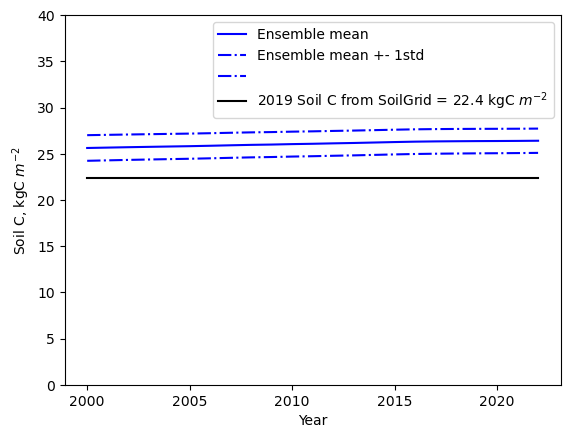

In [102]:
can_std = np.nanstd(arr_soilc_mean[can_idx_all,0:nyr], axis=0)
can_mean = np.nanmean(arr_soilc_mean[can_idx_all,0:nyr], axis=0)
plt.plot(np.arange(2000,2023), can_mean[30:53], 'b-')
plt.plot(np.arange(2000,2023), can_mean[30:53]+can_std[30:53], 'b-.')
plt.plot(np.arange(2000,2023), can_mean[30:53]-can_std[30:53], 'b-.')
plt.plot(np.arange(2000,2023), 22.4*np.ones((23)), 'k-')
plt.legend(['Ensemble mean', 'Ensemble mean +- 1std' , ' ', '2019 Soil C from SoilGrid = 22.4 kgC $m^{-2}$'])
plt.ylim([0, 40])
plt.xlabel('Year')
plt.ylabel('Soil C, kgC $m^{-2}$')

### Plot heat map of patch age

In [58]:
############################################################
### open the file and read in coordinate data
############################################################

## define the sizes of each dimension
## since the model simulation restarts at every 30 years
## time variable from historical file is disrupted
## create the axis on my own, in the unit of years.
nagebins = len(patch_age_bins)
nsizebins = len(cohort_size_bins)

## because the bin edges read in define the lower edges, add a last index to each to
## represent the upper edge of the distribution (even though there isn't one, really)
# time = np.append(time,time[ntim-1]+31.0)
patch_age_bins = np.append(patch_age_bins,patch_age_bins[nagebins-1]*1.5)
cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[nsizebins-1]*1.5)


In [79]:
patch_age_bins = np.array([0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
                   11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21.,
                   22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.,
                   33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
                   44., 45., 46., 47., 48., 49., 50., 75.])

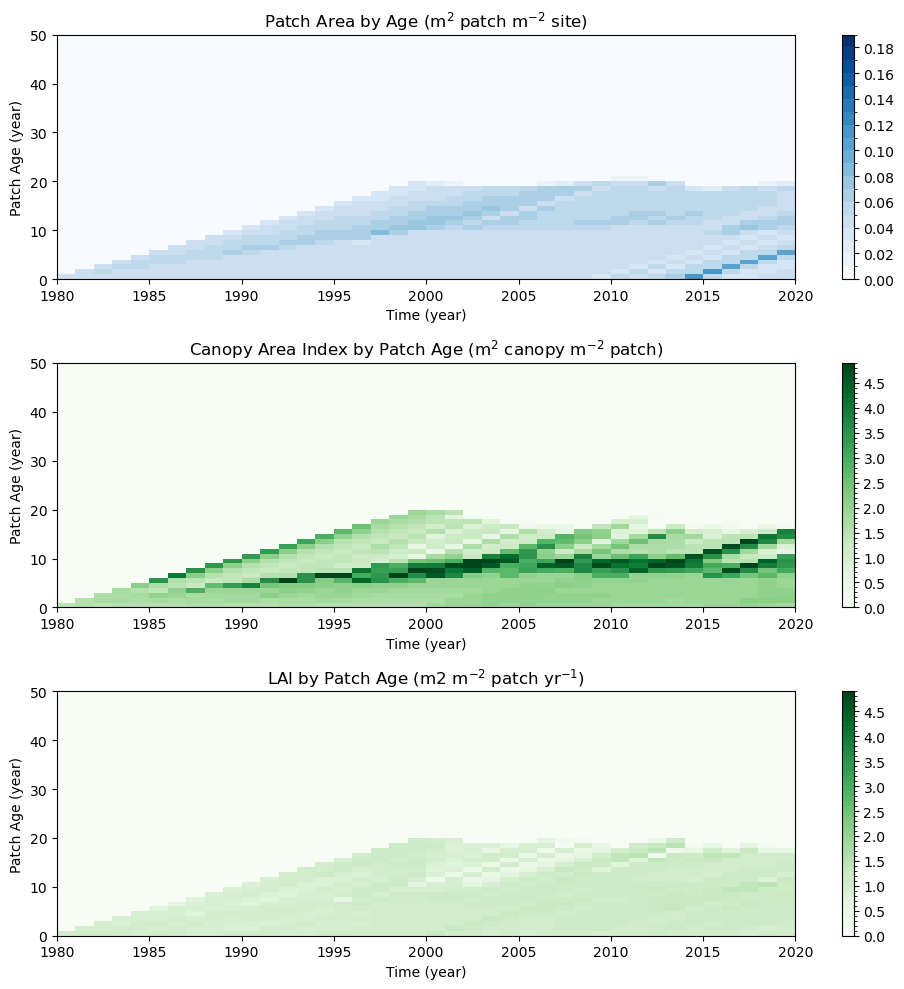

In [83]:
# Need to pick one ensemble
# candidates with age structure problem: 5, 6, 9, 13, 14, 15, 19
iens = 6
# 0 - monthly, 1 - annual
plot_mode = 1

if(plot_mode == 0):
    time = np.arange(0,601)
    ntim = len(time)

    # productivity and canopy structure as a function of patch age
    # rename of certain variables
    # GPP_BY_AGE [not available as default output any more] 
    LAI_BY_AGE = arr_lai_age[iens, :, :, :]
    PATCH_AREA_BY_AGE = arr_age[iens, :, :, :] + 1e-7
    CANOPY_AREA_BY_AGE = arr_can_area[iens, :, :, :]

    # population numbers and basal area as a functino of cohort size
    BA_SCLS = arr_ba[iens, :, :, :]
    NPLANT_CANOPY_SCLS = arr_num_can_sz[iens, :, :, :]
    NPLANT_UNDERSTORY_SCLS = arr_num_ustory_sz[iens, :, :, :]

    # growth and mortality rates as a function of plant size
    DDBH_CANOPY_SCLS = arr_ddbh_can_sz[iens, :, :, :]
    DDBH_UNDERSTORY_SCLS = arr_ddbh_ustory_sz[iens, :, :, :]
    MORTALITY_CANOPY_SCLS = arr_mort[iens, :, :, :]
    MORTALITY_UNDERSTORY_SCLS = arr_mort_ustory[iens, :, :, :]

else:
    time = np.arange(1980,2021)
    time_act = np.arange(1980,2020)
    ntim = len(time_act)
    
    LAI_BY_AGE = np.zeros((ntim, nagebins, 1)) 
    PATCH_AREA_BY_AGE = np.zeros((ntim, nagebins, 1))
    CANOPY_AREA_BY_AGE = np.zeros((ntim, nagebins, 1))

    BA_SCLS = np.zeros((ntim, nsizebins, 1))
    NPLANT_CANOPY_SCLS = np.zeros((ntim, nsizebins, 1))
    NPLANT_UNDERSTORY_SCLS = np.zeros((ntim, nsizebins, 1))

    DDBH_CANOPY_SCLS = np.zeros((ntim, nsizebins, 1))
    DDBH_UNDERSTORY_SCLS = np.zeros((ntim, nsizebins, 1))
    MORTALITY_CANOPY_SCLS = np.zeros((ntim, nsizebins, 1))
    MORTALITY_UNDERSTORY_SCLS = np.zeros((ntim, nsizebins, 1))

    for iyr in time_act:
        idx = 12*(iyr - 1850)
        LAI_BY_AGE[iyr-1980,:,:] = np.nanmean(arr_lai_age[iens, idx:idx+12, :, :], axis=0) 
        PATCH_AREA_BY_AGE[iyr-1980,:,:] = np.nanmean(arr_age[iens, idx:idx+12, :, :], axis=0) + 1e-7
        CANOPY_AREA_BY_AGE[iyr-1980,:,:] = np.nanmean(arr_can_area[iens, idx:idx+12, :, :], axis=0)

        # population numbers and basal area as a functino of cohort size
        BA_SCLS[iyr-1980,:,:] = np.nanmean(arr_ba[iens, idx:idx+12, :, :], axis=0)
        NPLANT_CANOPY_SCLS[iyr-1980,:,:] = np.nanmean(arr_num_can_sz[iens, idx:idx+12, :, :], axis=0)
        NPLANT_UNDERSTORY_SCLS[iyr-1980,:,:] = np.nanmean(arr_num_ustory_sz[iens, idx:idx+12, :, :], axis=0)

        # growth and mortality rates as a function of plant size
        DDBH_CANOPY_SCLS[iyr-1980,:,:] = np.nanmean(arr_ddbh_can_sz[iens, idx:idx+12, :, :], axis=0)
        DDBH_UNDERSTORY_SCLS[iyr-1980,:,:] = np.nanmean(arr_ddbh_ustory_sz[iens, idx:idx+12, :, :], axis=0)
        MORTALITY_CANOPY_SCLS[iyr-1980,:,:] = np.nanmean(arr_mort[iens, idx:idx+12, :, :], axis=0)
        MORTALITY_UNDERSTORY_SCLS[iyr-1980,:,:] = np.nanmean(arr_mort_ustory[iens, idx:idx+12, :, :], axis=0)
    
############################################################
### first, look at the productivity and canopy structure
############################################################

# set up the page
fig1, (f1ax0, f1ax1, f1ax2) = plt.subplots(nrows=3, figsize=(10, 10))

## set up the first plot: the fractional area of patches of a given age range
levels = np.arange(0.,0.2, 0.01)
cmap = plt.get_cmap('Blues')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f1ax0.pcolormesh(time, patch_age_bins, PATCH_AREA_BY_AGE[:,:,0].transpose(), cmap=cmap, norm=norm)
fig1.colorbar(im, ax=f1ax0)
f1ax0.set_title(r'Patch Area by Age (m$^2$ patch m$^{-2}$ site)')
f1ax0.set_ylabel('Patch Age (year)')
f1ax0.set_ylim([0, 50])
if(plot_mode == 0):
    f1ax0.set_xlabel('Time (month)')
    f1ax0.axvline(x = 432, color = 'k')
else:
    f1ax0.set_xlabel('Time (year)')
    f1ax0.set_xlim([1980, 2020])
    # f1ax0.axvline(x = 1886, color = 'k')

# Mask out the canopy area and LAI with patch area less than 1e-2
CANOPY_AREA_BY_AGE[PATCH_AREA_BY_AGE<0.01] = 0.0
LAI_BY_AGE[PATCH_AREA_BY_AGE<0.01] = 0.0

## set up the second plot: the canopy coverage of patches of a given age (where 1 means canopy closure)
levels = np.arange(0.,5.0, 0.1)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f1ax1.pcolormesh(time, patch_age_bins, (CANOPY_AREA_BY_AGE / PATCH_AREA_BY_AGE)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig1.colorbar(im, ax=f1ax1)
f1ax1.set_title(r'Canopy Area Index by Patch Age (m$^2$ canopy m$^{-2}$ patch)')
f1ax1.set_ylabel('Patch Age (year)')
f1ax1.set_ylim([0, 50])
if(plot_mode == 0):
    f1ax1.set_xlabel('Time (month)')
    f1ax1.axvline(x = 432, color = 'k')
else:
    f1ax1.set_xlabel('Time (year)')
    f1ax1.set_xlim([1980, 2020])
    f1ax1.axvline(x = 1886, color = 'k')


## set up the third plot: the GPP, conditional on patch age
levels = np.arange(0., 5.0, 0.1)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f1ax2.pcolormesh(time, patch_age_bins, (LAI_BY_AGE )[:,:,0].transpose(), cmap=cmap, norm=norm)
fig1.colorbar(im, ax=f1ax2)
f1ax2.set_title(r'LAI by Patch Age (m$2$ m$^{-2}$ patch yr$^{-1}$)')
f1ax2.set_ylabel('Patch Age (year)')
f1ax2.set_ylim([0, 50])
if(plot_mode == 0):
    f1ax2.set_xlabel('Time (month)')
    f1ax2.axvline(x = 432, color = 'k')
else:
    f1ax2.set_xlabel('Time (year)')
    f1ax2.set_xlim([1980, 2020])
    f1ax2.axvline(x = 1886, color = 'k')

# show the plot
fig1.tight_layout()
plt.show()



In [84]:
## Redefine the cohort size bins
cohort_size_bins = np.array([0.00000000e+00, 7.50000000e+00, 1.50000000e+01,
                   2.00000000e+01, 3.00000000e+01, 4.00000000e+01,
                   5.00000000e+01, 6.00000000e+01, 7.00000000e+01,
                   8.00000000e+01, 9.00000000e+01, 1.00000000e+02,
                   110, 120])

In [86]:
time

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

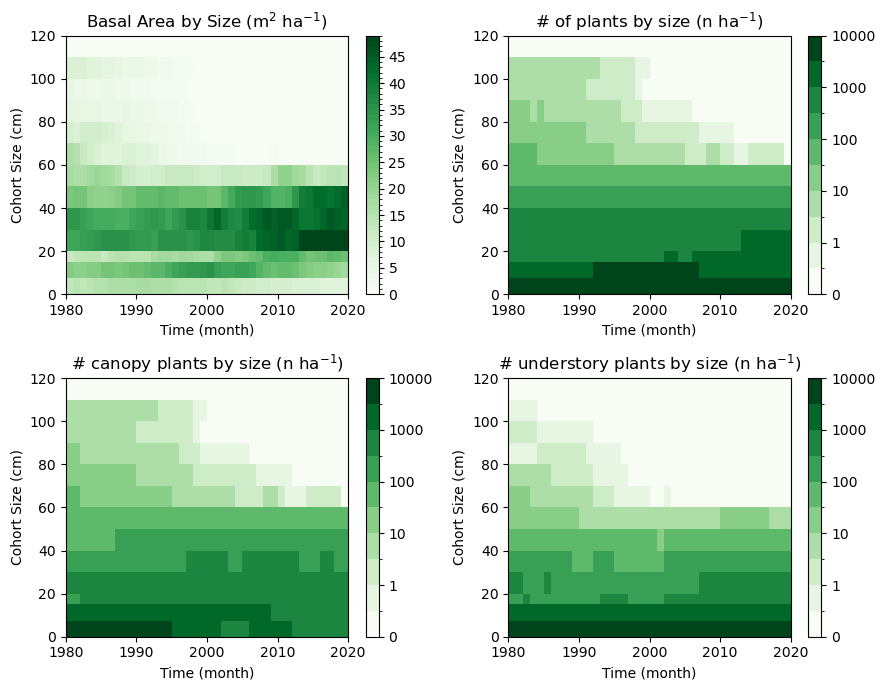

/tmp/ipykernel_1781113/2047976600.py:70: RuntimeWarning: invalid value encountered in divide
  im = f3ax0.pcolormesh(time, cohort_size_bins, 100.0*(DDBH_CANOPY_SCLS / NPLANT_CANOPY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
/tmp/ipykernel_1781113/2047976600.py:82: RuntimeWarning: invalid value encountered in divide
  im = f3ax1.pcolormesh(time, cohort_size_bins, 100.0*(DDBH_UNDERSTORY_SCLS / NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
/tmp/ipykernel_1781113/2047976600.py:94: RuntimeWarning: invalid value encountered in divide
  im = f3ax2.pcolormesh(time, cohort_size_bins, (MORTALITY_CANOPY_SCLS / NPLANT_CANOPY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
/tmp/ipykernel_1781113/2047976600.py:106: RuntimeWarning: invalid value encountered in divide
  im = f3ax3.pcolormesh(time, cohort_size_bins, (MORTALITY_UNDERSTORY_SCLS / NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)


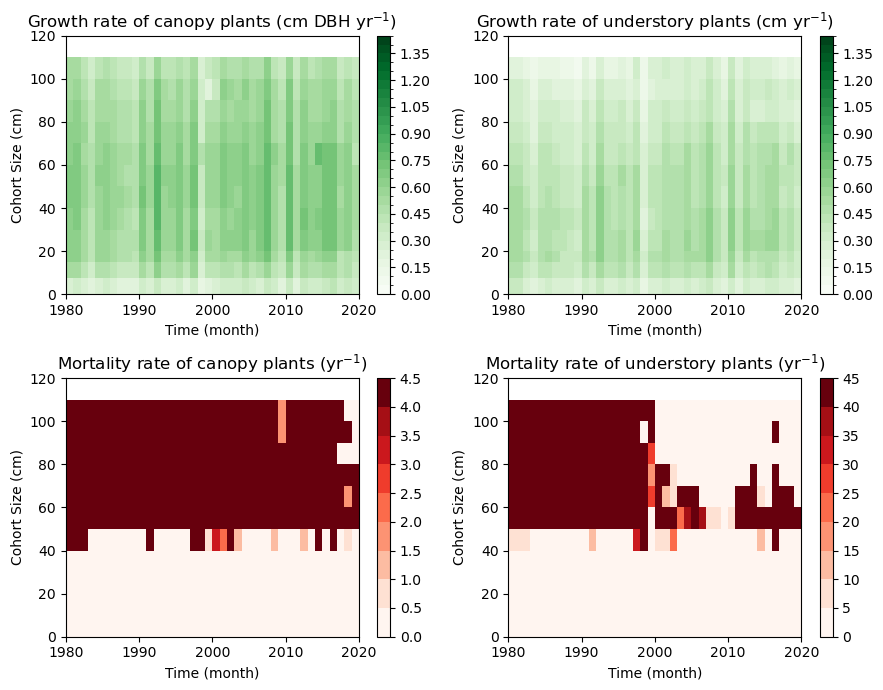

In [91]:
############################################################
### next, look at the evolution of the plant size structure
############################################################

# set up the page
fig2, ((f2ax0, f2ax1), (f2ax2, f2ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

## set up the first plot: evolution of basal area of plants of a given size
levels = np.arange(0.,50, 1)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f2ax0.pcolormesh(time, cohort_size_bins, 1e5*BA_SCLS[:,:,0].transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax0)
f2ax0.axvline(x = 432, color = 'k')
f2ax0.set_title(r'Basal Area by Size (m$^2$ ha$^{-1}$)')
f2ax0.set_xlabel('Time (month)')
f2ax0.set_ylabel('Cohort Size (cm)')
f2ax0.set_xlim([1980, 2020])

## set up the second plot: evolution of the population density of plants of a given size
# sum the canopy and understory plants to get size distribution of all plants
levels = np.array([0.1,0.3,1.,3.,10.,30., 100.,300.,1000., 3000., 10000.]) # do a pseudo-log scale here
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f2ax1.pcolormesh(time, cohort_size_bins, 1e5*(NPLANT_CANOPY_SCLS + NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax1)
f2ax1.axvline(x = 432, color = 'k')
f2ax1.set_title(r'# of plants by size (n ha$^{-1}$)')
f2ax1.set_xlabel('Time (month)')
f2ax1.set_ylabel('Cohort Size (cm)')
f2ax1.set_xlim([1980, 2020])

## set up the third plot: evolution of the population density of canopy plants of a given size
# use same levels & colorbar as second plot above
im = f2ax2.pcolormesh(time, cohort_size_bins, 1e5*(NPLANT_CANOPY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax2)
f2ax2.axvline(x = 432, color = 'k')
f2ax2.set_title(r'# canopy plants by size (n ha$^{-1}$)')
f2ax2.set_xlabel('Time (month)')
f2ax2.set_ylabel('Cohort Size (cm)')
f2ax2.set_xlim([1980, 2020])

## set up the fourth plot: evolution of the population density of understory plants of a given size
# use same levels & colorbar as second plot above
im = f2ax3.pcolormesh(time, cohort_size_bins, 1e5*(NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax3)
f2ax3.axvline(x = 432, color = 'k')
f2ax3.set_title(r'# understory plants by size (n ha$^{-1}$)')
f2ax3.set_xlabel('Time (month)')
f2ax3.set_ylabel('Cohort Size (cm)')
f2ax3.set_xlim([1980, 2020])

# show the plot
fig2.tight_layout()
plt.show()

############################################################
### next, look at the growth and mortality rates
### for all of these rates, you need to divide the rate by the population
### size in post-processing to get meaningful units
############################################################

# set up the page
fig3, ((f3ax0, f3ax1), (f3ax2, f3ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

## set up the first plot: growth rate (in diameter increment) in the canopy
levels = np.arange(0.,1.5, 0.05)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax0.pcolormesh(time, cohort_size_bins, 100.0*(DDBH_CANOPY_SCLS / NPLANT_CANOPY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax0)
f3ax0.axvline(x = 432, color = 'k')
f3ax0.set_title(r'Growth rate of canopy plants (cm DBH yr$^{-1}$)')
f3ax0.set_xlabel('Time (month)')
f3ax0.set_ylabel('Cohort Size (cm)')
f3ax0.set_xlim([1980, 2020])

## set up the second plot: growth rate in the understory, units as above
levels = np.arange(0.,1.5, 0.05)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax1.pcolormesh(time, cohort_size_bins, 100.0*(DDBH_UNDERSTORY_SCLS / NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax1)
f3ax1.axvline(x = 432, color = 'k')
f3ax1.set_title(r'Growth rate of understory plants (cm yr$^{-1}$)')
f3ax1.set_xlabel('Time (month)')
f3ax1.set_ylabel('Cohort Size (cm)')
f3ax1.set_xlim([1980, 2020])

## set up the third plot: mortality rate in the canopy, in units of fraction of trees per year of a given size class and canopy position
levels = np.arange(0.,5.0, 0.5)
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax2.pcolormesh(time, cohort_size_bins, (MORTALITY_CANOPY_SCLS / NPLANT_CANOPY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax2)
f3ax2.axvline(x = 432, color = 'k')
f3ax2.set_title(r'Mortality rate of canopy plants (yr$^{-1}$)')
f3ax2.set_xlabel('Time (month)')
f3ax2.set_ylabel('Cohort Size (cm)')
f3ax2.set_xlim([1980, 2020])

## set up the fourth plot: mortality rate in the understory, units as above
levels = np.arange(0.,50.0, 5.0)
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax3.pcolormesh(time, cohort_size_bins, (MORTALITY_UNDERSTORY_SCLS / NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax3)
f3ax3.axvline(x = 432, color = 'k')
f3ax3.set_title(r'Mortality rate of understory plants (yr$^{-1}$)')
f3ax3.set_xlabel('Time (month)')
f3ax3.set_ylabel('Cohort Size (cm)')
f3ax3.set_xlim([1980, 2020])

# show the plot
fig3.tight_layout()
plt.show()

In [ ]:
(p1 * d**p2)/2

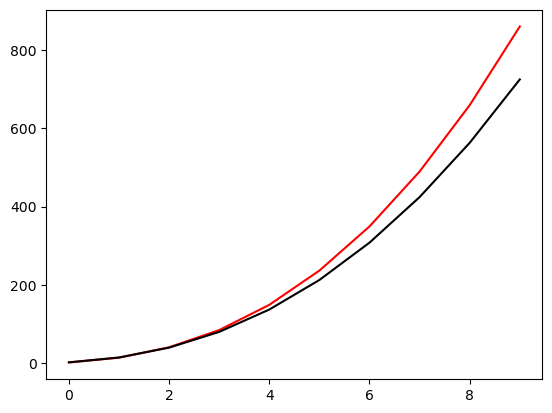

In [96]:
plt.plot(abg_bl, 'r-')
plt.plot(abg_nl, 'k-')

In [27]:
age_annual_mean = np.zeros((2,40,7))
age_patch_mean = np.zeros((2,40,7))
for iyr in np.arange(0,40):
    age_annual_mean[:,iyr,:] = np.nanmean(arr_age[:,12*iyr:12+12*iyr,:,0], axis=1)
    age_patch_mean[:,iyr,:] = np.nanmean(arr_age_patch[:,12*iyr:12+12*iyr,:,0], axis=1)

In [7]:
age_1850_mean = np.nanmean(np.nanmean(arr_age[:,0:120,:,0], axis=0), axis=0)
age_1980_mean = np.nanmean(np.nanmean(arr_age[:,1500:1620, :, 0], axis = 0), axis=0)
age_1850_std = np.nanstd(arr_age[:,0:120,:,0], axis=0)
age_1980_std = np.nanstd(arr_age[:,1500:1620, :, 0], axis = 0)

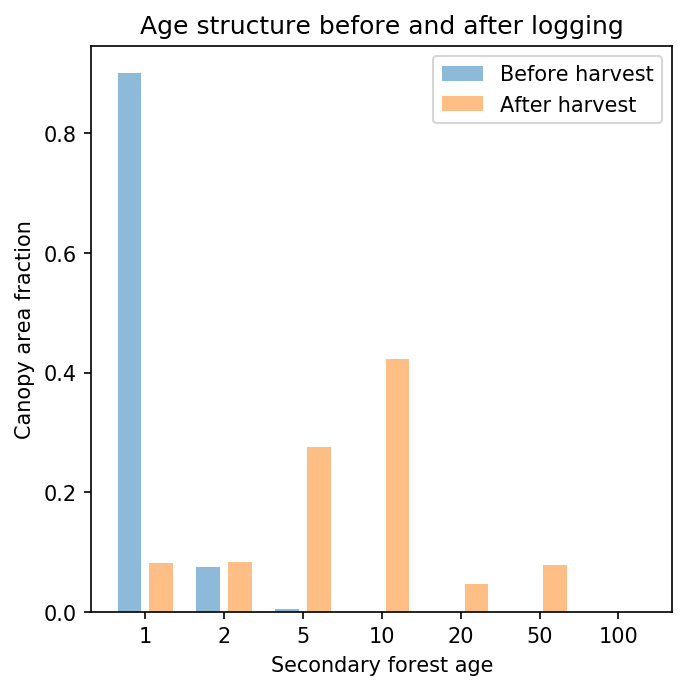

In [8]:
# Barplot to show age distribution
fig = plt.figure(figsize=(5,5), dpi=150)
objects = ('1', '2', '5', '10', '20', '50', '100')
y_pos = np.arange(len(objects))
y_pos_1 = np.arange(len(objects))-0.2
y_pos_2 = np.arange(len(objects))+0.2

plt.bar(y_pos_1, age_1850_mean, align='center', alpha=0.5, width = 0.3)
plt.bar(y_pos_2, age_1980_mean, align='center', alpha=0.5, width = 0.3)
plt.xticks(y_pos, objects)
plt.ylabel('Canopy area fraction')
plt.xlabel('Secondary forest age')
plt.title('Age structure before and after logging')
plt.legend(['Before harvest', 'After harvest'])


Text(0.5,0,'Age')

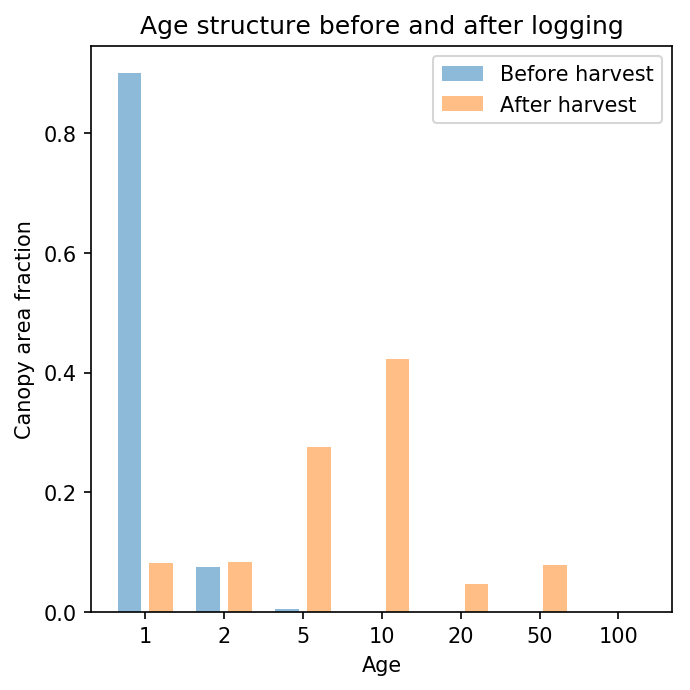

In [9]:
# Barplot to show age distribution
fig = plt.figure(figsize=(5,5), dpi=150)
objects = ('1', '2', '5', '10', '20', '50', '100')
y_pos = np.arange(len(objects))
y_pos_1 = np.arange(len(objects))-0.2
y_pos_2 = np.arange(len(objects))+0.2

plt.bar(y_pos_1, age_1850_mean, align='center', alpha=0.5, width = 0.3)
plt.bar(y_pos_2, age_1980_mean, align='center', alpha=0.5, width = 0.3)
plt.xticks(y_pos, objects)
plt.ylabel('Canopy area fraction')
plt.title('Age structure before and after logging')
plt.legend(['Before harvest', 'After harvest'])
plt.xlabel('Age')

### Check harvested carbon and other C variables

(7.5, 30.0)

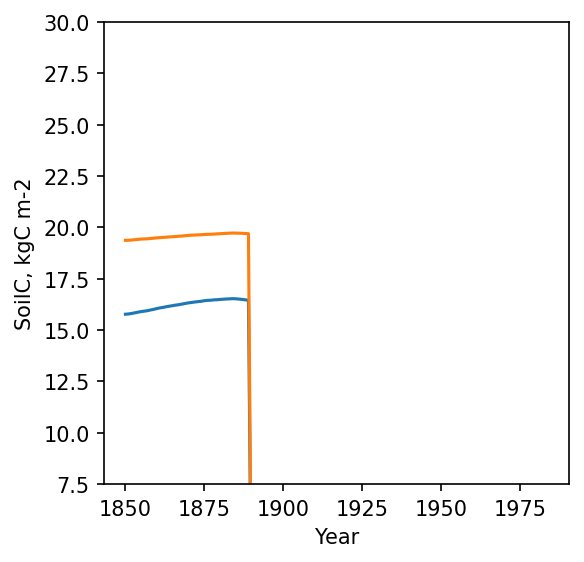

In [ ]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax_yr = np.arange(1850,1985)
for i in np.arange(0,2):
    plt.plot(ax_yr, arr_soilc_mean[i,:])
plt.xlabel('Year')
plt.ylabel('SoilC, kgC m-2')
plt.ylim([7.5, 30])

(0.0, 20.0)

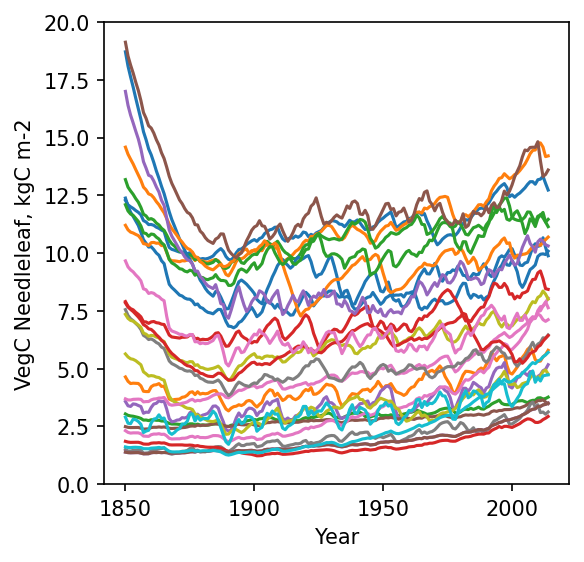

In [62]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax_yr = np.arange(1850,2015)
for i in np.arange(0,27):
    plt.plot(ax_yr[0:165], arr_vegc_nl_mean[i,0:165])
plt.xlabel('Year')
plt.ylabel('VegC Needleleaf, kgC m-2')
plt.ylim([0, 20])

(0.0, 15.0)

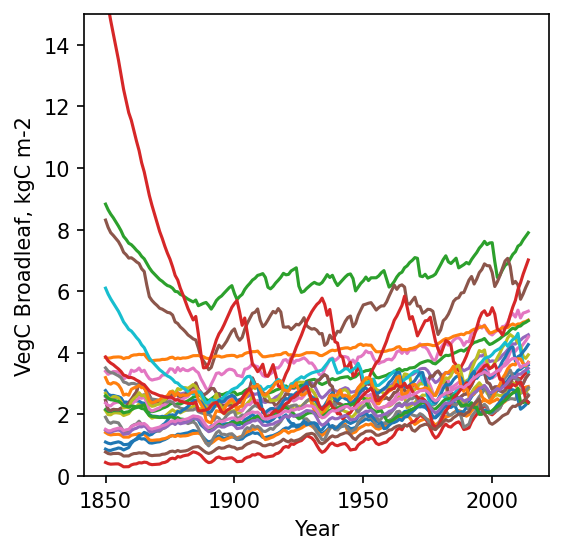

In [63]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax_yr = np.arange(1850,2015)
for i in np.arange(0,27):
    plt.plot(ax_yr[0:165], arr_vegc_bl_mean[i,0:165])
plt.xlabel('Year')
plt.ylabel('VegC Broadleaf, kgC m-2')
plt.ylim([0, 15])

### Other codes

In [61]:
# Check the mean biomass from the product
data_name = "./biomass_Mgha_30m.tif"
tiff = rasterio.open(data_name)
ddd = tiff.read()[0,:,:]
ddd[ddd<1e-3] = np.nan
np.nanmean(ddd)
# rasterio.plot.show(tiff, title = "Bottom Temperature in the Medierranean Sea")

86.25922

In [62]:
# Check the vegetation size-class structure and age structure of Puebla State
oak_pine_df = pd.read_csv('Size_distributions_Puebla.csv')
oak_pine_df

lower_bin_edge         All         Oak        Pine
0             7.5  829.444444  284.444444  210.000000
1            15.0  227.222222   74.444444   86.111111
2            20.0  214.444444   70.000000   63.888889
3            30.0  124.444444   30.555556   53.333333
4            40.0   50.555556    6.111111   36.666667
5            50.0   33.333333    2.777778   28.888889
6            60.0    0.000000    0.000000    0.000000